**EXP4 Predicitng Missing Cell-Types from Dissociated and Classic Bulks using the Residual**

Data downloaded from: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE217517

Cell types per sample from original paper: https://github.com/greenelab/deconvolution_pilot/tree/main/data/cell_labels

Code references: https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

*This file includes EXP4 specifics (outlined below), as well as the data preprocessing, QC, and creates the pseudobulks used in other experiments.*

In [1]:
# import the dependencies
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
sys.path.insert(1, '../../../../../')

from functions import sn_sc_preprocess
from functions import validation_processing as vp
from importlib import reload
reload(sn_sc_preprocess)
reload(vp)
# general imports
import warnings
import numpy as np
from numpy import random
from numpy import array
from numpy import diag
from numpy import dot
from numpy import zeros
import pandas as pd
import scanpy as sc
from anndata import AnnData as ad
from tabulate import tabulate

import tensorflow as tf
import sklearn as sk
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import FunctionTransformer
import scipy as sp
from scipy.stats import spearmanr, pearsonr
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
from scipy.stats import wilcoxon
import scipy.stats as stats
from collections import Counter
import scipy as sp
from scipy.optimize import nnls
from scipy.stats import ttest_ind
# Images, plots, display, and visualization
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.colors as mcolors
import seaborn as sns

import seaborn as sns
from scipy import stats
from openTSNE import TSNE
from openTSNE import TSNEEmbedding
from openTSNE import affinity
from openTSNE import initialization
#sklearns
from sklearn.decomposition import FastICA
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
#from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier

from biomart import BiomartServer
import rpy2 as rpy2
from rpy2.robjects import pandas2ri
from rpy2.robjects import r, globalenv
from rpy2.robjects.packages import importr
# programming stuff
import time
import os, sys
from io import StringIO 
import pickle
import requests
from pathlib import Path

In [2]:
#####################
### set the study ###
#####################
#results paths:
res_name = "MCT_hgsoc_EXP4"
actual_path = os.getcwd()
data_path = f"{actual_path}/../data/EXP4/"
cibersort_results_path = f"{actual_path}/../data/EXP4/cibersort_results/"
cibersort_path = f"{actual_path}/../data/EXP4/cibersort/"
random_seed = 88
nmf_cut = 'minimum_value'
num_samples = 10000
bulks_type= f"real"
types_of_bulks = ["classic_rrna", "dissociated_rrna", "dissociated_polya"]

## **Reading and QCing the data:**

Classic Bulks (Not Dissociated)

In [3]:
bulks_path = os.path.join(data_path, f"{res_name}_bulks.csv")
bulks_path = Path(bulks_path)
bulks = pd.read_csv(bulks_path)
bulks = bulks.drop(labels=["Unnamed: 0"], axis = 1)
bulks

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,AC133551.1,AC136612.1,AC136616.1,AC136616.3,AC136616.2,AC141272.1,AC023491.2,AC007325.1,AC007325.4,AC007325.2
0,7,0,0,6,0,1,28,0,6,1,...,0,0,16,0,0,6,2,4,47,36
1,1,0,0,12,0,0,77,0,10,0,...,0,0,81,0,0,0,2,0,18,13
2,0,0,0,5,0,1,26,0,10,0,...,0,0,8,0,0,0,0,0,46,24
3,0,0,0,3,0,0,51,0,7,0,...,0,0,1,0,6,1,0,0,10,23
4,0,0,0,2,0,0,27,0,12,0,...,0,0,54,0,0,0,1,0,8,0
5,8,0,0,5,0,3,59,0,0,0,...,0,0,3,0,0,0,0,0,18,34
6,0,0,0,5,0,0,81,1,3,0,...,0,0,7,0,1,3,0,0,2,3
7,2,0,0,6,0,2,47,0,6,0,...,0,0,0,0,2,13,0,0,16,7


Dissociated Bulks:

In [4]:
dbulks_path = os.path.join(data_path, f"{res_name}_dissociated_bulks.csv")
dbulks_path = Path(dbulks_path)
diss_bulks = pd.read_csv(dbulks_path)
diss_bulks = diss_bulks.drop(labels=["Unnamed: 0"], axis=1)
diss_bulks

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,AC133551.1,AC136612.1,AC136616.1,AC136616.3,AC136616.2,AC141272.1,AC023491.2,AC007325.1,AC007325.4,AC007325.2
0,3,0,0,2,0,0,15,0,1,0,...,0,0,19,0,1,1,3,4,39,28
1,1,0,0,5,0,0,63,1,6,0,...,0,0,27,0,0,0,0,0,8,6
2,3,2,0,1,0,0,7,0,5,0,...,0,0,17,0,0,2,0,0,57,30
3,4,0,0,2,0,0,37,0,2,0,...,0,0,2,0,0,0,0,0,10,21
4,2,0,0,4,0,0,31,0,3,0,...,0,0,6,0,0,6,0,0,6,2
5,1,0,0,1,0,0,33,0,2,0,...,0,0,6,0,0,1,0,0,20,16
6,1,0,0,1,0,0,26,0,5,0,...,0,0,19,0,2,11,0,1,15,3
7,8,0,0,1,0,1,38,0,0,0,...,0,0,4,0,0,4,0,0,10,9


Dissociated polyA:

In [5]:
disspolyA_bulks_path = os.path.join(data_path, f"{res_name}_dissociatedpolyA_bulks.csv")
disspolyA_bulks_path = Path(disspolyA_bulks_path)
disspolya_bulks = pd.read_csv(disspolyA_bulks_path)
disspolya_bulks = disspolya_bulks.drop(labels=["Unnamed: 0"], axis = 1)
disspolya_bulks

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,AC133551.1,AC136612.1,AC136616.1,AC136616.3,AC136616.2,AC141272.1,AC023491.2,AC007325.1,AC007325.4,AC007325.2
0,17,2,0,10,0,2,66,0,15,1,...,0,1,35,0,0,9,9,7,56,78
1,2,1,0,7,0,3,134,0,8,0,...,0,4,58,0,1,2,0,0,15,11
2,0,0,0,1,0,0,14,0,10,0,...,0,0,35,0,0,6,0,0,51,27
3,5,1,0,6,0,0,159,0,16,0,...,0,0,2,0,2,6,0,0,27,32
4,4,0,0,13,0,4,92,0,5,0,...,0,0,16,0,0,1,0,0,4,6
5,7,0,0,11,0,9,114,0,12,0,...,0,0,9,0,0,1,0,0,10,17
6,0,0,0,5,0,1,69,0,12,0,...,0,1,33,0,4,30,0,0,6,3
7,2,0,0,6,0,1,93,0,9,1,...,0,0,6,0,2,16,0,0,10,12


Gene maps:

In [6]:
genes_path = os.path.join(data_path, f"gene_maps.csv")
genes_path = Path(genes_path)
genes = pd.read_csv(genes_path, index_col=0)
genes

,Name,Ens
0,MIR1302-2HG,ENSG00000243485
1,FAM138A,ENSG00000237613
2,OR4F5,ENSG00000186092
3,AL627309.1,ENSG00000238009
4,AL627309.3,ENSG00000239945
...,...,...
36596,AC141272.1,ENSG00000277836
36597,AC023491.2,ENSG00000278633
36598,AC007325.1,ENSG00000276017
36599,AC007325.4,ENSG00000278817


In [7]:
bulks.columns = genes["Name"]
diss_bulks.columns = genes["Name"]

And all single-cells:

In [8]:
#saved as anndata objects
adata_path = os.path.join(data_path, f"{res_name}_adatas_combined.h5ad")
adata_path = Path(adata_path)
adata = sc.read_h5ad(adata_path)
adata

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 16723 × 13724
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids'

In [9]:
print(Counter(adata.obs["cell_types"]))
# define the number of cells and the list of missing cell counts
num_cells = len(adata.obs.cell_types.unique())
cell_order = adata.obs.cell_types.unique()

Counter({'T cells': 7419, 'Plasma cells': 1983, 'Epithelial cells': 1694, 'Fibroblasts': 1587, 'Endothelial cells': 1189, 'Macrophages': 1116, 'NK cells': 842, 'Monocytes': 272, 'B cells': 264, 'pDC': 170, 'DC': 98, 'ILC': 89})


In [10]:
#combining the dissociated and non dissociated
combo = pd.DataFrame(np.concatenate([bulks.values, diss_bulks.values]), 
    columns = bulks.columns,index = range(1,17))

In [11]:
#matching index 
bulks.index = range(1,9)
diss_bulks.index = range(1,9)
disspolya_bulks.index = range(1,9)
combo.index = range(1,17)
bulks

Name,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,AC133551.1,AC136612.1,AC136616.1,AC136616.3,AC136616.2,AC141272.1,AC023491.2,AC007325.1,AC007325.4,AC007325.2
1,7,0,0,6,0,1,28,0,6,1,...,0,0,16,0,0,6,2,4,47,36
2,1,0,0,12,0,0,77,0,10,0,...,0,0,81,0,0,0,2,0,18,13
3,0,0,0,5,0,1,26,0,10,0,...,0,0,8,0,0,0,0,0,46,24
4,0,0,0,3,0,0,51,0,7,0,...,0,0,1,0,6,1,0,0,10,23
5,0,0,0,2,0,0,27,0,12,0,...,0,0,54,0,0,0,1,0,8,0
6,8,0,0,5,0,3,59,0,0,0,...,0,0,3,0,0,0,0,0,18,34
7,0,0,0,5,0,0,81,1,3,0,...,0,0,7,0,1,3,0,0,2,3
8,2,0,0,6,0,2,47,0,6,0,...,0,0,0,0,2,13,0,0,16,7


In [12]:
# Putting bulks into dicitonary 
pseudo_df = dict()
pseudo_df['classic_rrna'] = bulks
pseudo_df["dissociated_rrna"] = diss_bulks
pseudo_df["dissociated_polya"] = disspolya_bulks

## **Reading In and QCing the CIBERSORTx Results:**

In [13]:
#import all CIBERSORTx results and real proportions
cibersort_prop = dict()
ref_cibersort = dict()

for bulktype in types_of_bulks:
    #import cibersort proportions
    cibersort_results_path_prop = os.path.join(cibersort_results_path, f"{bulktype}/CIBERSORTx_Results.txt")
    cibersort_results_path_prop = Path(cibersort_results_path_prop)
    # Open the CSV file in read mode
    cibersort_prop[bulktype] = pd.read_csv(cibersort_results_path_prop, sep="\t")
    cibersort_prop[bulktype] = cibersort_prop[bulktype].drop(labels = ["Mixture", "P-value", "Correlation", "RMSE"], axis = 1)
    #and the reference used in cibersort
    ref_results_path = os.path.join(cibersort_results_path, f"{bulktype}/CIBERSORTx_{res_name}_real_0missing_signal_inferred_phenoclasses.CIBERSORTx_{res_name}_real_0missing_signal_inferred_refsample.bm.K999.txt")
    ref_results_path = Path(ref_results_path)

    # Open the CSV file in read mode
    ref_cibersort[bulktype] = pd.read_csv(ref_results_path, sep="\t")
    ref_cibersort[bulktype] = ref_cibersort[bulktype].rename(columns = {'NAME':'gene_ids'})
    ref_cibersort[bulktype].index = ref_cibersort[bulktype]["gene_ids"]
    ref_cibersort[bulktype] = ref_cibersort[bulktype].drop(labels= "gene_ids", axis = 1)

In [14]:
ref_cibersort

{'classic_rrna':              Plasma cells   Monocytes    T cells  Endothelial cells  \
 gene_ids                                                              
 A1BG             1.000000    1.000000  50.983555           1.000000   
 A2M              1.000000    1.000000   1.000000        1279.809270   
 AAMDC            1.000000    1.000000   1.000000           1.000000   
 ABCA1          182.832648  652.716038   1.000000           1.000000   
 ABCB1            1.000000    1.000000   1.000000           1.000000   
 ...                   ...         ...        ...                ...   
 ZRSR2            1.000000    1.000000  66.699501           1.000000   
 ZSCAN16.AS1      1.000000   43.284386   1.000000           1.000000   
 ZSWIM6         118.685098  349.845266   1.000000           1.000000   
 ZYX              1.000000  180.443637  71.045215         127.220768   
 ZZEF1            1.000000   46.941648   1.000000           1.000000   
 
               NK cells  Epithelial cells     

In [15]:
#We gave the same reference, so the reference genes is the same for all bulks
cibersort_genes = np.intersect1d(ref_cibersort["classic_rrna"].index,
                    ref_cibersort["dissociated_rrna"].index, )
cibersort_genes = np.intersect1d(cibersort_genes,
                    ref_cibersort["dissociated_polya"].index, )

In [16]:
# #Reading in the CIBERSORTx barcode genes
# cibersort_ref = dict()
# cibersort_genes = dict()
# cibersort_results_path = f"{actual_path}/../data/EXP4/cibersort_results/"
# print("genes to keep per experiment:")
# for num in range(1,9):    
#     # read in cibersort genes / cibersort reference
#     cibersort_path_ = os.path.join(cibersort_results_path, f"CIBERSORTx_{res_name}_{bulks_type}_{num}missing_signal_inferred_phenoclasses.CIBERSORTx_{res_name}_{bulks_type}_{num}missing_signal_inferred_refsample.bm.K999.txt")
#     cibersort_path_ = Path(cibersort_path_)
#     cibersort_df = pd.read_csv(cibersort_path_, sep="\t")
#     cibersort_genes[num] = pd.DataFrame(columns = cibersort_df["NAME"].values.tolist())
#     cibersort_df.index = cibersort_genes[num].columns
#     cibersort_ref[num] = cibersort_df.drop(columns = "NAME", inplace=False)
# cibersort_genes = cibersort_genes[1].columns
# cibersort_genes = cibersort_genes.tolist()
# cibersort_genes

## Reference:

Extracting makers:

In [17]:
#From deconv paper:
#Erythocyte markers
eryth_markers = ['ALAS2','HBB', 'HBA2','HBA1']
#Dissociation Response
diss_response = ['PYDC1', 'PRRR35', 'AGXT', 'EREG', 'CSF3', 'ASTL'
    'HSPC3', 'SELE', 'IL1B', 'TRIM72', 'CTRB2', 'RNF223', 'CSF2','CXCL8',
    'KRT17', 'PMAIP1', 'CSF2','ADRA2B','CCL3L1', 'SLC32A1','DLX2','CXCR1','LEP',
    'TEX48','FCGR3B','CXCR2','THRSP','TMC2', 'AL845331.2','SLC7A10','BOD1L2',
    'SERPINI2','BLID']
#And adipocyte markers
adipocyte_genes = ["PLIN1", "CIDEC", "GPD1", "ACVR1C"]

#adipocyte markers from CellMarker
markers_path = os.path.join(data_path, f"CellMarker.csv")
markers_path = Path(markers_path)
markers = pd.read_csv(markers_path)
adip_markers = markers["Cell Marker"]
adip_markers = adip_markers.tolist()
adip_markers.append(adipocyte_genes)
#deleting genes that are also highly expressed in cancer
removed_marker = ['CD44','CD45','CD34','CD29','CD137','CD106']
for remove_gene in removed_marker:
    adip_markers.remove(remove_gene)
adip_markers

['ACRP30',
 'ADIPOR1',
 'ADIPOR2',
 'BSCL2',
 'CHC22',
 'CIDEA',
 'DLK1',
 'DLK2',
 'FABP4',
 'FATP1',
 'FATP2',
 'FATP4',
 'FATP5',
 'FATP6',
 'GLUT4',
 'Galectin-12',
 'HLA-ABC',
 'Leptin',
 'PGC-1-alpha',
 'PPARgamma',
 'Perilipin-2',
 'UCP1',
 'VSTM2A',
 'VSTM2B',
 'ZIC1',
 'gACRP30',
 ['PLIN1', 'CIDEC', 'GPD1', 'ACVR1C']]

In [18]:
#Some of the names are not in the right format, so reassigning manually
adip_markers = np.array(adip_markers)
adip_markers = ['ACRP30', 'ADIPOR1', 'ADIPOR2', 'CIDEA', 'FABP4',
       'FATP1', 'FATP2', 'FATP4', 'FATP5', 'FATP6', 'GLUT4',
       'LGALS12', 'LEP', 'PPARG',
       'PLIN1', 'UCP1', 'GACRP30','ACVR1C', 
       'CIDEC', 'GPD1', 'ADIPOQ', 'MRAP', 'TRARG1', 'ADGRL4', 'LIPE']

/var/folders/d3/x10lxf7x1n37__s3n36qxmlw0000gp/T/ipykernel_15519/1432233138.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  adip_markers = np.array(adip_markers)


In [19]:
#merging the cibersort, adipocyte, erythocyte, and dissociation genes:
gene_ids = list()
gene_ids.extend(cibersort_genes)
gene_ids.extend(adip_markers)
gene_ids.extend(eryth_markers)
gene_ids.extend(diss_response)
len(gene_ids)

3916

In [20]:
#and set intersection of gene_ids from adata, bulks, and cibersort:
genes_in_both = np.intersect1d(gene_ids, bulks.columns)
genes_in_both = np.intersect1d(genes_in_both, diss_bulks.columns)
genes_in_both = np.intersect1d(genes_in_both, adata.var_names)
gene_ids = genes_in_both.copy()
len(gene_ids)

3817

In [21]:
#cutting all to only include marker genes and barcode genes from cibersort.
bulks = bulks [gene_ids]
diss_bulks= diss_bulks[gene_ids]
disspolya_bulks = disspolya_bulks[gene_ids]
combo = combo[gene_ids]
adata = adata[:, gene_ids]

Normalizing bulk counts:

Normalizing bulk counts:

In [22]:
combo_norm = pd.DataFrame(columns=bulks.columns)
for idx, bulk in combo.iterrows():
    pseudo_df = pd.DataFrame(bulk)
    clip_upper = np.quantile(pseudo_df, 0.90)
    pseudo_df = np.clip(pseudo_df, 0, clip_upper)
    #and normalize to values between 0 and 1
    scaler = MinMaxScaler()
    scaler.fit(pseudo_df)
    normalized_pseudo_df = scaler.transform(pseudo_df)
    combo_norm = combo_norm.append(pd.DataFrame(normalized_pseudo_df.T, columns = combo_norm.columns))
combo = combo_norm.copy()
combo.index = range(1, len(combo)+1)
combo

Name,A1BG,A2M,AAMDC,ABCA1,ABCB1,ABCB8,ABCC1,ABCE1,ABHD12,ABHD14B,...,ZNHIT3,ZNHIT6,ZNRD2,ZNRF2,ZPR1,ZRANB1,ZRSR2,ZSWIM6,ZYX,ZZEF1
1,0.027023,1.0,0.020617,1.0,0.039233,0.260819,0.429361,0.309060,0.194964,0.166940,...,0.062452,0.162537,0.044237,0.108091,0.263021,0.205973,0.042836,0.282838,0.903759,0.681573
2,0.031114,1.0,0.159639,1.0,0.009305,0.355627,1.000000,0.479209,0.354754,0.332364,...,0.083164,0.147427,0.034894,0.117767,0.293108,0.114277,0.065426,0.357081,0.629834,0.768828
3,0.034347,1.0,0.041887,1.0,0.017173,0.144509,0.774902,0.435201,0.536148,0.261372,...,0.092988,0.061573,0.050683,0.160007,0.285248,0.257602,0.028902,0.480439,0.235821,1.000000
4,0.005686,1.0,0.024510,1.0,0.096667,0.116667,0.514314,0.690196,0.157451,0.311373,...,0.053137,0.165098,0.074118,0.122745,0.422353,0.166667,0.035098,0.208039,0.676863,0.710980
5,0.015649,1.0,0.041117,1.0,0.028536,0.177662,0.560908,0.586990,0.365143,0.166922,...,0.099417,0.111384,0.061062,0.123964,0.256214,0.089598,0.101258,0.339368,0.674747,0.872047
6,0.068092,1.0,0.050615,1.0,0.090108,0.319352,0.818467,0.278497,0.350220,0.100322,...,0.082618,0.161378,0.082391,0.184529,0.391075,0.257842,0.081710,0.196559,0.305052,0.704072
7,0.007126,1.0,0.017948,1.0,0.100560,0.150179,0.821368,0.567198,0.196368,0.183963,...,0.046717,0.155986,0.065984,0.136455,0.415171,0.160473,0.079181,0.515467,0.950433,0.992927
8,0.018793,1.0,0.031089,1.0,0.074475,0.175398,0.547538,0.306018,0.365876,0.183982,...,0.070298,0.177022,0.045010,0.142685,0.213679,0.196279,0.103939,0.283978,0.775834,1.000000
9,0.037230,1.0,0.015686,1.0,0.097706,0.189742,0.397437,0.301433,0.222436,0.135881,...,0.054239,0.125298,0.065578,0.098084,0.364743,0.171788,0.039687,0.312583,1.000000,0.545413
10,0.026917,1.0,0.063140,1.0,0.095707,0.260534,0.624751,0.413067,0.341619,0.139240,...,0.072445,0.143892,0.050844,0.153197,0.223315,0.145221,0.085737,0.400106,0.930480,0.873322


In [23]:
bulks_norm = pd.DataFrame(columns=bulks.columns)
for idx, bulk in bulks.iterrows():
    pseudo_df = pd.DataFrame(bulk)
    clip_upper = np.quantile(pseudo_df, 0.90)
    pseudo_df = np.clip(pseudo_df, 0, clip_upper)
    #and normalize to values between 0 and 1
    scaler = MinMaxScaler()
    scaler.fit(pseudo_df)
    normalized_pseudo_df = scaler.transform(pseudo_df)
    bulks_norm = bulks_norm.append(pd.DataFrame(normalized_pseudo_df.T, columns = bulks_norm.columns))
bulks = bulks_norm.copy()
bulks.index = range(1, len(bulks)+1)
bulks

Name,A1BG,A2M,AAMDC,ABCA1,ABCB1,ABCB8,ABCC1,ABCE1,ABHD12,ABHD14B,...,ZNHIT3,ZNHIT6,ZNRD2,ZNRF2,ZPR1,ZRANB1,ZRSR2,ZSWIM6,ZYX,ZZEF1
1,0.027023,1.0,0.020617,1.0,0.039233,0.260819,0.429361,0.309060,0.194964,0.166940,...,0.062452,0.162537,0.044237,0.108091,0.263021,0.205973,0.042836,0.282838,0.903759,0.681573
2,0.031114,1.0,0.159639,1.0,0.009305,0.355627,1.000000,0.479209,0.354754,0.332364,...,0.083164,0.147427,0.034894,0.117767,0.293108,0.114277,0.065426,0.357081,0.629834,0.768828
3,0.034347,1.0,0.041887,1.0,0.017173,0.144509,0.774902,0.435201,0.536148,0.261372,...,0.092988,0.061573,0.050683,0.160007,0.285248,0.257602,0.028902,0.480439,0.235821,1.000000
4,0.005686,1.0,0.024510,1.0,0.096667,0.116667,0.514314,0.690196,0.157451,0.311373,...,0.053137,0.165098,0.074118,0.122745,0.422353,0.166667,0.035098,0.208039,0.676863,0.710980
5,0.015649,1.0,0.041117,1.0,0.028536,0.177662,0.560908,0.586990,0.365143,0.166922,...,0.099417,0.111384,0.061062,0.123964,0.256214,0.089598,0.101258,0.339368,0.674747,0.872047
6,0.068092,1.0,0.050615,1.0,0.090108,0.319352,0.818467,0.278497,0.350220,0.100322,...,0.082618,0.161378,0.082391,0.184529,0.391075,0.257842,0.081710,0.196559,0.305052,0.704072
7,0.007126,1.0,0.017948,1.0,0.100560,0.150179,0.821368,0.567198,0.196368,0.183963,...,0.046717,0.155986,0.065984,0.136455,0.415171,0.160473,0.079181,0.515467,0.950433,0.992927
8,0.018793,1.0,0.031089,1.0,0.074475,0.175398,0.547538,0.306018,0.365876,0.183982,...,0.070298,0.177022,0.045010,0.142685,0.213679,0.196279,0.103939,0.283978,0.775834,1.000000


In [24]:
diss_bulks_norm = pd.DataFrame(columns=diss_bulks.columns)
for idx, bulk in diss_bulks.iterrows():
    pseudo_df = pd.DataFrame(bulk)
    clip_upper = np.quantile(pseudo_df, 0.90)
    pseudo_df = np.clip(pseudo_df, 0, clip_upper)
    #and normalize to values between 0 and 1
    scaler = MinMaxScaler()
    scaler.fit(pseudo_df)
    normalized_pseudo_df = scaler.transform(pseudo_df)
    diss_bulks_norm = diss_bulks_norm.append(pd.DataFrame(normalized_pseudo_df.T, columns = diss_bulks_norm.columns))
diss_bulks = diss_bulks_norm.copy()
diss_bulks.index = range(1, len(diss_bulks)+1)
diss_bulks

Name,A1BG,A2M,AAMDC,ABCA1,ABCB1,ABCB8,ABCC1,ABCE1,ABHD12,ABHD14B,...,ZNHIT3,ZNHIT6,ZNRD2,ZNRF2,ZPR1,ZRANB1,ZRSR2,ZSWIM6,ZYX,ZZEF1
1,0.037230,1.0,0.015686,1.0,0.097706,0.189742,0.397437,0.301433,0.222436,0.135881,...,0.054239,0.125298,0.065578,0.098084,0.364743,0.171788,0.039687,0.312583,1.000000,0.545413
2,0.026917,1.0,0.063140,1.0,0.095707,0.260534,0.624751,0.413067,0.341619,0.139240,...,0.072445,0.143892,0.050844,0.153197,0.223315,0.145221,0.085737,0.400106,0.930480,0.873322
3,0.062923,1.0,0.017591,1.0,0.075778,0.165426,0.701624,0.322057,0.477334,0.153586,...,0.038227,0.028078,0.109608,0.139378,0.648512,0.207713,0.025034,0.175575,0.554127,0.725643
4,0.019555,1.0,0.023848,1.0,0.126634,0.182915,0.765287,0.336497,0.212010,0.152390,...,0.048412,0.095631,0.096823,0.145474,0.508919,0.166937,0.044119,0.205332,1.000000,0.705428
5,0.012337,1.0,0.020047,1.0,0.077362,0.162177,0.837360,0.464172,0.319986,0.319729,...,0.067081,0.136733,0.094582,0.165262,0.654364,0.224375,0.116428,0.264470,1.000000,0.766937
6,0.041172,1.0,0.032775,1.0,0.110244,0.288748,0.675551,0.254347,0.355924,0.108619,...,0.064738,0.146270,0.144374,0.175795,0.763855,0.228886,0.071239,0.232678,0.653069,0.565307
7,0.020689,1.0,0.018048,1.0,0.086499,0.166615,0.462869,0.321345,0.436897,0.146146,...,0.055245,0.078576,0.066250,0.198090,0.453845,0.118414,0.115112,0.261258,1.000000,0.762205
8,0.015741,1.0,0.022136,1.0,0.260465,0.131585,0.412219,0.382705,0.271287,0.148064,...,0.035663,0.092233,0.072802,0.149786,0.526834,0.191352,0.065424,0.252595,0.767131,0.765901


In [25]:
disspolya_bulks_norm = pd.DataFrame(columns= disspolya_bulks.columns)
for idx, bulk in disspolya_bulks.iterrows():
    pseudo_df = pd.DataFrame(bulk)
    clip_upper = np.quantile(pseudo_df, 0.90)
    pseudo_df = np.clip(pseudo_df, 0, clip_upper)
    #and normalize to values between 0 and 1
    scaler = MinMaxScaler()
    scaler.fit(pseudo_df)
    normalized_pseudo_df = scaler.transform(pseudo_df)
    disspolya_bulks_norm = disspolya_bulks_norm.append(pd.DataFrame(normalized_pseudo_df.T, columns = disspolya_bulks_norm.columns))
disspolya_bulks = disspolya_bulks_norm.copy()
disspolya_bulks.index = range(1, len(disspolya_bulks)+1)
disspolya_bulks

,A1BG,A2M,AAMDC,ABCA1,ABCB1,ABCB8,ABCC1,ABCE1,ABHD12,ABHD14B,...,ZNHIT3,ZNHIT6,ZNRD2,ZNRF2,ZPR1,ZRANB1,ZRSR2,ZSWIM6,ZYX,ZZEF1
1,0.020981,1.0,0.015995,0.660730,0.078592,0.310700,0.434716,0.265345,0.194023,0.170272,...,0.053110,0.127756,0.035176,0.096942,0.357578,0.149222,0.057611,0.416644,1.000000,0.686489
2,0.026927,1.0,0.050882,1.000000,0.073166,0.301950,0.499907,0.387558,0.331662,0.215785,...,0.084494,0.159331,0.048097,0.100650,0.226184,0.100464,0.171773,0.410956,1.000000,0.748375
3,0.027008,1.0,0.018445,1.000000,0.071143,0.183128,0.503711,0.299065,0.403803,0.156339,...,0.057090,0.029643,0.057968,0.128892,0.681569,0.175223,0.031839,0.190593,0.941988,0.763471
4,0.009591,1.0,0.028542,1.000000,0.097992,0.193325,0.649310,0.310962,0.212161,0.209850,...,0.052578,0.096374,0.048534,0.143290,0.562759,0.133930,0.097414,0.225681,1.000000,0.895329
5,0.006530,1.0,0.015762,0.991624,0.061470,0.202423,0.822075,0.372197,0.298793,0.393362,...,0.054715,0.130145,0.059443,0.131721,0.622805,0.160767,0.179906,0.278753,1.000000,0.884220
6,0.015471,1.0,0.028396,0.826610,0.102812,0.336049,0.689527,0.234412,0.315682,0.138062,...,0.065408,0.155491,0.058750,0.134929,0.682085,0.194070,0.112408,0.247337,1.000000,0.635869
7,0.011381,1.0,0.020122,1.000000,0.064325,0.191324,0.452416,0.251196,0.423223,0.184727,...,0.061686,0.086756,0.036616,0.149761,0.435758,0.082632,0.189180,0.245588,1.000000,0.828798
8,0.008521,1.0,0.022465,1.000000,0.214731,0.160196,0.353236,0.351687,0.213181,0.188238,...,0.039662,0.097295,0.036563,0.131379,0.525052,0.162675,0.093577,0.352772,1.000000,0.891922


In [26]:
# removed cells that are unlabeled or unclassified already
cell_type_id = adata.obs["cell_types"].values
cell_type_id = np.unique(cell_type_id)
cell_type_remove = ["Mast cells", "Erythroid"]
cell_type_id = set(cell_type_id).difference(set(cell_type_remove))
adata = adata[adata.obs["cell_types"].isin(cell_type_id)]
#matching obs
print(np.unique(adata.obs["cell_types"].values))

['B cells' 'DC' 'Endothelial cells' 'Epithelial cells' 'Fibroblasts' 'ILC'
 'Macrophages' 'Monocytes' 'NK cells' 'Plasma cells' 'T cells' 'pDC']


## References

In [27]:
#Making cell type reference without scaling
ref_raw_all = dict()
idx = 1
cell_types = adata.obs["cell_types"].unique()
ref_raw = pd.DataFrame(index = gene_ids, columns = cell_types)
for cell_type in cell_types:
    cell_df = adata[adata.obs["cell_types"].isin([cell_type])]
    cell_sample = sk.utils.resample(cell_df, n_samples = num_samples, replace=True)
    x = cell_sample.X.sum(axis=0)
    sum_over_genes = pd.DataFrame(x).T
    #and save to df dict
    ref_raw[cell_type] = sum_over_genes.values
ref_raw_all = ref_raw
#deleting unknown cell types, not assigned
ref_raw_all = ref_raw.drop(columns=["Unknown1", "Unknown2"], errors='ignore')
ref_raw_all

,Plasma cells,Monocytes,T cells,Endothelial cells,NK cells,Epithelial cells,ILC,Fibroblasts,B cells,DC,Macrophages,pDC
A1BG,2917.509521,2878.129150,4386.382324,1869.306274,5143.255371,4420.375488,4281.513672,4571.532227,3803.552979,3134.358643,3291.743408,14070.711914
A2M,6295.620117,1426.854248,1660.599854,92529.757812,1712.331665,3941.936035,2443.854248,30111.998047,960.600830,4585.709961,11816.369141,570.031494
AAMDC,3084.807861,2140.219727,1090.912598,6798.145020,835.461548,11685.311523,1522.218140,4966.655762,1536.527588,337.178680,1851.940430,1109.799683
ABCA1,14177.766602,59095.515625,1252.569702,5804.643555,1915.343384,4528.298340,4211.395020,18276.195312,3814.128662,6442.780273,99967.500000,1046.779663
ABCB1,1276.520508,131.900375,2247.855225,6378.239258,7909.698242,104.525635,5697.776367,422.176971,1316.468872,384.972626,360.131958,54.369316
...,...,...,...,...,...,...,...,...,...,...,...,...
ZRANB1,1897.569092,2576.553711,2320.824707,2980.884521,2278.110352,2441.264160,5150.409180,3427.924072,3258.383301,732.713196,3002.509521,666.005432
ZRSR2,1638.852173,2132.520020,5851.566406,2223.283447,5788.329102,1585.030640,3957.102539,2381.428467,5856.665039,2283.327148,3115.242432,1143.904663
ZSWIM6,10230.965820,31271.654297,3091.497070,9137.583984,3586.192383,3813.313965,4797.528320,15699.522461,5566.840332,4330.536133,25991.287109,2371.914551
ZYX,2059.235352,15737.378906,5759.594727,9036.136719,7855.781738,7215.829102,4244.895996,7943.625000,2153.236816,10300.955078,12702.376953,2231.765381


In [28]:
#clippign before scaling to 95th pecentile
ref_raw_val = ref_raw_all.values
clip_upper = np.quantile(ref_raw_val, 0.90)
ref_raw_val = np.clip(ref_raw_val, 0, clip_upper)
#and scaling to be between values 0 and 1 to use for NNLS
scaler = MinMaxScaler()
scaler.fit(ref_raw_val)
ref_df = scaler.transform(ref_raw_val)
ref_df = pd.DataFrame(ref_df, index = gene_ids, columns = ref_raw_all.columns)
ref_raw = pd.DataFrame(ref_raw_val, index = gene_ids, columns = ref_raw_all.columns)
ref_df_all = ref_df
ref_raw_all = ref_raw
ref_df_all

,Plasma cells,Monocytes,T cells,Endothelial cells,NK cells,Epithelial cells,ILC,Fibroblasts,B cells,DC,Macrophages,pDC
A1BG,0.313740,0.309505,0.471457,0.201020,0.553091,0.475354,0.460421,0.491609,0.409023,0.337060,0.353984,1.000000
A2M,0.677012,0.153440,0.178200,1.000000,0.184139,0.423904,0.262805,1.000000,0.103300,0.493134,1.000000,0.061300
AAMDC,0.331731,0.230153,0.116909,0.731052,0.089843,1.000000,0.163695,0.534099,0.165234,0.036259,0.199152,0.119345
ABCA1,1.000000,1.000000,0.134301,0.624214,0.205970,0.486960,0.452881,1.000000,0.410160,0.692838,1.000000,0.112568
ABCB1,0.137273,0.014184,0.241381,0.685897,0.850586,0.011240,0.612722,0.045400,0.141569,0.041399,0.038728,0.005847
...,...,...,...,...,...,...,...,...,...,...,...,...
ZRANB1,0.204059,0.277075,0.249231,0.320556,0.244981,0.262526,0.553860,0.368629,0.350397,0.078794,0.322881,0.071620
ZRSR2,0.176237,0.229325,0.629090,0.239085,0.622460,0.170450,0.425535,0.256092,0.629808,0.245542,0.335004,0.123012
ZSWIM6,1.000000,1.000000,0.332145,0.982629,0.385649,0.410073,0.515912,1.000000,0.598642,0.465693,1.000000,0.255069
ZYX,0.221444,1.000000,0.619196,0.971719,0.844788,0.775969,0.456484,0.854234,0.231553,1.000000,1.000000,0.239997


Here, we use the SC-reference to deconvolve the dissociated bulk and the non-dissociated bulk (from macthed tissue).

## Evalutating CIBERSORTx Performance:

In [29]:
# # Sample data for "Classic Bulks" and "Dissociated Bulks"
# classic_bulks_values = calc_res_tot_bulks.values[0]
# dissociated_bulks_values = calc_res_tot_dissbulks.values[0]
# dissociatedpolya_bulks_values = calc_res_tot_disspolyabulks.values[0]

# # Create x-coordinates for the bars
# x_coordinates = np.arange(len(classic_bulks_values))
# # Width of each bar
# bar_width = 0.25

# plt.figure(figsize=(15, 6))

# # Plot "Classic Bulks" residuals
# plt.bar(x_coordinates, classic_bulks_values, width=bar_width, alpha=0.7, label='Classic Bulks')

# # Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
# plt.bar(x_coordinates + bar_width, dissociated_bulks_values, width=bar_width, alpha=0.7, label='Dissociated Bulks')

# # Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
# plt.bar(x_coordinates + bar_width + bar_width, dissociatedpolya_bulks_values, width=bar_width, alpha=0.7, label='Dissociated polyA Bulks')

# plt.xlabel('Sample ID')
# plt.ylabel('Residuals (sum of squared difference)')
# plt.title('Residuals for Classic Bulks and Dissociated Bulks')
# plt.xticks(x_coordinates + bar_width, x_coordinates + 1)  # Adjust x-axis labels

# # Move the legend to the upper right corner
# plt.legend(loc='lower right')

# plt.show()

In [30]:
# # Sample data for "Classic Bulks" and "Dissociated Bulks"
# classic_bulks_values = calc_res_tot_bulks.values[0]
# dissociated_bulks_values = calc_res_tot_dissbulks.values[0]

# # Create x-coordinates for the bars
# x_coordinates = np.arange(len(classic_bulks_values))
# # Width of each bar
# bar_width = 0.4

# plt.figure(figsize=(15, 6))

# # Plot "Classic Bulks" residuals
# plt.bar(x_coordinates, classic_bulks_values, width=bar_width, alpha=0.7, label='Classic Bulks')

# # Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
# plt.bar(x_coordinates + bar_width, dissociated_bulks_values, width=bar_width, alpha=0.7, label='Dissociated Bulks')

# plt.xlabel('Sample ID')
# plt.ylabel('Residuals (sum of squared difference)')
# plt.title('Residuals for Classic Bulks and Dissociated Bulks')
# plt.xticks(x_coordinates + bar_width, x_coordinates + 1)  # Adjust x-axis labels

# # Move the legend to the upper right corner
# plt.legend(loc='lower right')

# plt.show()

In [31]:
# # Sample data for "Classic Bulks" and "Dissociated Bulks"
# classic_bulks_values = calc_res_tot_bulks.values[0]
# dissociated_bulks_values = calc_res_tot_dissbulks.values[0]

# # Combine data into a DataFrame
# df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(classic_bulks_values) +
#                                   ['Dissociated Bulks'] * len(dissociated_bulks_values),
#                    'Residuals': np.concatenate([classic_bulks_values, dissociated_bulks_values])})

# # Create a figure and axis for violin plots
# plt.figure(figsize=(9, 6))
# ax = plt.gca()

# # Create violin plots for the two datasets
# sns.violinplot(x='Sample Type', y='Residuals', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightgreen'])

# # Add labels to the x-axis
# ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, fontname='Arial',fontweight='bold')

# # Calculate p-value for the Wilcoxon signed-rank test
# t_statistic, p_value = wilcoxon(classic_bulks_values, dissociated_bulks_values)

# # Set a significance level (e.g., 0.05)
# alpha = 0.05

# # Determine if the difference is statistically significant
# if p_value < alpha:
#     significance_label = f"Significant p={np.round(p_value, 3)}"
#     asterisks = vp.convert_pvalue_to_asterisks(p_value)
#     x1, x2 = 0, 1
#     y1, y2 = 22.5, max(df['Residuals']) + 2.4
#     # Add a line and asterisks to indicate statistical significance
#     plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
#     plt.text((x1 + x2) / 2, y2-.25, asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
# else:
#     significance_label = f"Not Significant p={np.round(p_value, 3)}"
#     # No asterisks for non-significant results

# # Add the significance label and the name of the statistical test to the plot
# #plt.text(.5, max(df['Residuals']), f'Wilcoxon T-Test: {significance_label}', fontsize=12, fontweight='bold', fontname='Arial')

# plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
# plt.ylabel('Residuals (sum of squared difference)', fontsize=16, fontname='Arial')
# plt.title('Deconv. Unexplained Variance: Classic Bulks and Dissociated Bulks', fontsize=16, fontname='Arial', fontweight='bold', x=0.5, y=1.03)
# plt.ylim(14.5, 24)
# plt.show()

In [32]:
# # Sample data for "Classic Bulks" and "Dissociated Bulks"
# classic_bulks_values = calc_res_tot_disspolyabulks.values[0]
# dissociated_bulks_values = calc_res_tot_dissbulks.values[0]

# # Combine data into a DataFrame
# df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(classic_bulks_values) +
#                                   ['Dissociated Bulks'] * len(dissociated_bulks_values),
#                    'Residuals': np.concatenate([classic_bulks_values, dissociated_bulks_values])})

# # Create a figure and axis for violin plots
# plt.figure(figsize=(9, 6))
# ax = plt.gca()

# # Create violin plots for the two datasets
# sns.violinplot(x='Sample Type', y='Residuals', data=df, ax=ax, inner='quartile', palette=['lightpink', 'lightgreen'])

# # Add labels to the x-axis
# ax.set_xticklabels(['Dissociated (polyA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, fontname='Arial',fontweight='bold')

# # Calculate p-value for the Wilcoxon signed-rank test
# # Perform the paired t-test
# t_statistic, p_value = wilcoxon(classic_bulks_values, dissociated_bulks_values)

# # Set a significance level (e.g., 0.05)
# alpha = 0.05

# # Determine if the difference is statistically significant
# if p_value < alpha:
#     significance_label = f"Significant p={np.round(p_value, 3)}"
#     asterisks = vp.convert_pvalue_to_asterisks(p_value)
#     x1, x2 = 0, 1
#     y1, y2 = 10, max(df['Residuals']) + 2.8
#     # Add a line and asterisks to indicate statistical significance
#     plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
#     plt.text((x1 + x2) / 2, y2, asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
# else:
#     significance_label = f"Not Significant p={np.round(p_value, 3)}"
#     significance_label = f"Significant p={np.round(p_value, 3)}"
#     asterisks = vp.convert_pvalue_to_asterisks(p_value)
#     x1, x2 = 0, 1
#     y1, y2 = 19.85, max(df['Residuals']) + 2
#     # Add a line and asterisks to indicate statistical significance
#     plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
#     plt.text((x1 + x2) / 2, y2+0.03, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
#     # No asterisks for non-significant results

# # Add the significance label and the name of the statistical test to the plot
# #plt.text(.5, max(df['Residuals']), f'Wilcoxon T-Test: {significance_label}', fontsize=12, fontweight='bold', fontname='Arial')

# plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
# plt.ylabel('Residuals (sum of squared difference)', fontsize=16, fontname='Arial')
# plt.title('Deconv. Unexplained Variance: Dissociated (polyA and -rRNA) Bulks', fontsize=16, fontname='Arial', fontweight='bold', x=0.5, y=1.03)
# plt.ylim(14.5, 24)
# plt.show()

## Residuals Prep

Putting bulks together for multiplication:

Recreate Matrices:

In [33]:
all_refs = ref_df

In [34]:
#recreate matrix with calculated proportion nnls and multiplying by the used reference
bulks_recreated_mat_all = pd.DataFrame(all_refs @ cibersort_prop['classic_rrna'].T)
bulks_recreated_mat_all = bulks_recreated_mat_all.T
bulks_recreated_mat_all.columns = gene_ids
bulks_recreated_mat_all   

,A1BG,A2M,AAMDC,ABCA1,ABCB1,ABCB8,ABCC1,ABCE1,ABHD12,ABHD14B,...,ZNHIT3,ZNHIT6,ZNRD2,ZNRF2,ZPR1,ZRANB1,ZRSR2,ZSWIM6,ZYX,ZZEF1
0,0.398915,0.238836,0.129842,0.494987,0.201208,0.119239,0.575926,0.389411,0.247537,0.372384,...,0.226213,0.227018,0.387879,0.379485,0.245672,0.313994,0.487530,0.547193,0.482218,0.349580
1,0.408225,0.316085,0.152530,0.510341,0.114775,0.108515,0.467964,0.375395,0.264980,0.356813,...,0.255629,0.238970,0.414163,0.402516,0.237455,0.252120,0.472889,0.554637,0.579631,0.344406
2,0.403924,0.201758,0.182150,0.474235,0.126318,0.114183,0.577375,0.390714,0.233521,0.440216,...,0.245343,0.255320,0.378474,0.462877,0.242872,0.311855,0.545816,0.586930,0.382525,0.373861
3,0.391914,0.238903,0.141434,0.506019,0.113705,0.106574,0.513344,0.376450,0.257941,0.407889,...,0.229526,0.226835,0.383023,0.436512,0.231826,0.278868,0.515611,0.578497,0.458090,0.361335
4,0.409043,0.196747,0.188982,0.460184,0.184172,0.122128,0.617399,0.403803,0.230785,0.418102,...,0.243353,0.256113,0.384920,0.429767,0.253450,0.334583,0.524077,0.558931,0.399247,0.364678
5,0.425645,0.186098,0.191508,0.445209,0.200519,0.132075,0.640159,0.411532,0.225116,0.419652,...,0.244485,0.263484,0.383606,0.439079,0.261456,0.346315,0.522892,0.556371,0.374167,0.367813
6,0.394428,0.222417,0.123562,0.484312,0.144903,0.106490,0.503722,0.371501,0.255350,0.395197,...,0.229614,0.226146,0.397383,0.419089,0.230095,0.265123,0.515757,0.549394,0.487468,0.360700
7,0.404475,0.179215,0.151971,0.457551,0.169165,0.121424,0.635405,0.389131,0.240377,0.439303,...,0.242563,0.258462,0.370391,0.479236,0.248725,0.338099,0.564151,0.586195,0.351016,0.393928


In [35]:
#recreate matrix with calculated proportion of CIBERSORtx and multiplying by the used reference
dissbulks_recreated_mat_all = pd.DataFrame(all_refs @ cibersort_prop['dissociated_rrna'].T)
dissbulks_recreated_mat_all = dissbulks_recreated_mat_all.T
dissbulks_recreated_mat_all.columns = gene_ids
dissbulks_recreated_mat_all 

,A1BG,A2M,AAMDC,ABCA1,ABCB1,ABCB8,ABCC1,ABCE1,ABHD12,ABHD14B,...,ZNHIT3,ZNHIT6,ZNRD2,ZNRF2,ZPR1,ZRANB1,ZRSR2,ZSWIM6,ZYX,ZZEF1
0,0.410148,0.237673,0.134577,0.479589,0.246774,0.121987,0.598266,0.384660,0.245564,0.364385,...,0.236608,0.247575,0.399618,0.390582,0.245621,0.314665,0.498062,0.547233,0.489844,0.361997
1,0.398725,0.292297,0.168045,0.536436,0.118335,0.107957,0.548126,0.377670,0.306948,0.411519,...,0.238044,0.247269,0.371592,0.509199,0.235773,0.307022,0.524933,0.635161,0.455027,0.385004
2,0.442302,0.185629,0.146523,0.402576,0.336354,0.127299,0.656697,0.370266,0.232255,0.386320,...,0.274538,0.313763,0.429391,0.459004,0.245778,0.314000,0.574521,0.545821,0.461182,0.411065
3,0.427535,0.202127,0.122739,0.421836,0.285267,0.115971,0.565492,0.362152,0.249782,0.373911,...,0.259728,0.280773,0.435564,0.432570,0.234899,0.271226,0.549547,0.524524,0.526576,0.389853
4,0.422650,0.225679,0.137612,0.456471,0.310417,0.131627,0.661491,0.391677,0.240470,0.359533,...,0.246137,0.267742,0.403360,0.390147,0.256328,0.345915,0.508469,0.540682,0.478858,0.371792
5,0.407868,0.204778,0.148932,0.470057,0.221429,0.127564,0.657025,0.395636,0.235679,0.402809,...,0.238136,0.254410,0.375538,0.429064,0.254387,0.351917,0.527691,0.571612,0.391943,0.377764
6,0.401225,0.239114,0.146850,0.490770,0.152795,0.110646,0.570801,0.374031,0.299796,0.418462,...,0.239576,0.252416,0.380012,0.518015,0.237076,0.305597,0.550867,0.605218,0.433736,0.400272
7,0.443015,0.206258,0.138098,0.408260,0.330490,0.120878,0.601184,0.361998,0.244098,0.372635,...,0.275799,0.309238,0.444509,0.445499,0.238805,0.284210,0.564324,0.533577,0.526331,0.401523


In [36]:
#recreate matrix with calculated proportion of CIBERSORtx and multiplying by the used reference
disspolyabulks_recreated_mat_all = pd.DataFrame(all_refs @  cibersort_prop['dissociated_polya'].T)
disspolyabulks_recreated_mat_all = disspolyabulks_recreated_mat_all.T
disspolyabulks_recreated_mat_all.columns = gene_ids
disspolyabulks_recreated_mat_all 

,A1BG,A2M,AAMDC,ABCA1,ABCB1,ABCB8,ABCC1,ABCE1,ABHD12,ABHD14B,...,ZNHIT3,ZNHIT6,ZNRD2,ZNRF2,ZPR1,ZRANB1,ZRSR2,ZSWIM6,ZYX,ZZEF1
0,0.414014,0.215371,0.138382,0.461338,0.251246,0.125006,0.628610,0.387492,0.244172,0.383358,...,0.242795,0.259004,0.395256,0.416234,0.250155,0.330354,0.522601,0.552603,0.452986,0.375328
1,0.394567,0.269112,0.153941,0.522021,0.117854,0.107426,0.546218,0.376112,0.307290,0.414913,...,0.233272,0.240019,0.371944,0.510366,0.235049,0.302449,0.531236,0.620230,0.446216,0.388193
2,0.454061,0.176329,0.139017,0.375616,0.391833,0.130147,0.669726,0.366140,0.232645,0.374423,...,0.284531,0.330393,0.447339,0.455523,0.247334,0.311490,0.584441,0.526234,0.491737,0.418556
3,0.433319,0.180573,0.128504,0.402790,0.298880,0.119621,0.598231,0.364200,0.241620,0.388446,...,0.267228,0.295009,0.434009,0.451078,0.238836,0.285105,0.571372,0.528392,0.491891,0.402056
4,0.405385,0.226393,0.152684,0.484011,0.153991,0.111766,0.551180,0.376942,0.243898,0.412475,...,0.243916,0.252365,0.390473,0.445867,0.235910,0.291352,0.535009,0.580671,0.442473,0.372921
5,0.406648,0.206613,0.158828,0.476373,0.185327,0.122996,0.632019,0.391576,0.230089,0.417227,...,0.241459,0.256638,0.374084,0.442506,0.249047,0.338055,0.536585,0.585355,0.380448,0.378398
6,0.401285,0.187320,0.194658,0.461605,0.117365,0.111594,0.558807,0.395183,0.237212,0.441885,...,0.242323,0.249101,0.384955,0.461161,0.242599,0.301249,0.539608,0.566705,0.389825,0.368093
7,0.439634,0.211954,0.138153,0.416753,0.314924,0.119560,0.590567,0.363043,0.245633,0.373339,...,0.272697,0.302837,0.441273,0.441166,0.238207,0.282429,0.558565,0.535620,0.528665,0.396527


In [37]:
#recreate matrix with calculated proportion of CIBERSORtx and multiplying by the used reference
combo_props = pd.concat([cibersort_prop["classic_rrna"], cibersort_prop["dissociated_rrna"]])
combo_recreated_mat_all = pd.DataFrame(all_refs @  combo_props.T)
combo_recreated_mat_all = combo_recreated_mat_all.T
idx = np.tile(range(1,9), 2)
combo_recreated_mat_all.index = idx
combo_recreated_mat_all 

,A1BG,A2M,AAMDC,ABCA1,ABCB1,ABCB8,ABCC1,ABCE1,ABHD12,ABHD14B,...,ZNHIT3,ZNHIT6,ZNRD2,ZNRF2,ZPR1,ZRANB1,ZRSR2,ZSWIM6,ZYX,ZZEF1
1,0.398915,0.238836,0.129842,0.494987,0.201208,0.119239,0.575926,0.389411,0.247537,0.372384,...,0.226213,0.227018,0.387879,0.379485,0.245672,0.313994,0.487530,0.547193,0.482218,0.349580
2,0.408225,0.316085,0.152530,0.510341,0.114775,0.108515,0.467964,0.375395,0.264980,0.356813,...,0.255629,0.238970,0.414163,0.402516,0.237455,0.252120,0.472889,0.554637,0.579631,0.344406
3,0.403924,0.201758,0.182150,0.474235,0.126318,0.114183,0.577375,0.390714,0.233521,0.440216,...,0.245343,0.255320,0.378474,0.462877,0.242872,0.311855,0.545816,0.586930,0.382525,0.373861
4,0.391914,0.238903,0.141434,0.506019,0.113705,0.106574,0.513344,0.376450,0.257941,0.407889,...,0.229526,0.226835,0.383023,0.436512,0.231826,0.278868,0.515611,0.578497,0.458090,0.361335
5,0.409043,0.196747,0.188982,0.460184,0.184172,0.122128,0.617399,0.403803,0.230785,0.418102,...,0.243353,0.256113,0.384920,0.429767,0.253450,0.334583,0.524077,0.558931,0.399247,0.364678
6,0.425645,0.186098,0.191508,0.445209,0.200519,0.132075,0.640159,0.411532,0.225116,0.419652,...,0.244485,0.263484,0.383606,0.439079,0.261456,0.346315,0.522892,0.556371,0.374167,0.367813
7,0.394428,0.222417,0.123562,0.484312,0.144903,0.106490,0.503722,0.371501,0.255350,0.395197,...,0.229614,0.226146,0.397383,0.419089,0.230095,0.265123,0.515757,0.549394,0.487468,0.360700
8,0.404475,0.179215,0.151971,0.457551,0.169165,0.121424,0.635405,0.389131,0.240377,0.439303,...,0.242563,0.258462,0.370391,0.479236,0.248725,0.338099,0.564151,0.586195,0.351016,0.393928
1,0.410148,0.237673,0.134577,0.479589,0.246774,0.121987,0.598266,0.384660,0.245564,0.364385,...,0.236608,0.247575,0.399618,0.390582,0.245621,0.314665,0.498062,0.547233,0.489844,0.361997
2,0.398725,0.292297,0.168045,0.536436,0.118335,0.107957,0.548126,0.377670,0.306948,0.411519,...,0.238044,0.247269,0.371592,0.509199,0.235773,0.307022,0.524933,0.635161,0.455027,0.385004


## **Calculate Residuals:**

1. Residual uses:

pseudobulks - recreated_mat_all (reference used normalized (all_refs) * calculated proportions (calc_prop_tot))

In [38]:
#Classic Bulks: Residual as the the difference between the recreated matrix and pseudobulks.
res = bulks.values - bulks_recreated_mat_all.values
residuals_bulks = pd.DataFrame(res, columns = bulks_recreated_mat_all.columns)
residuals_bulks

,A1BG,A2M,AAMDC,ABCA1,ABCB1,ABCB8,ABCC1,ABCE1,ABHD12,ABHD14B,...,ZNHIT3,ZNHIT6,ZNRD2,ZNRF2,ZPR1,ZRANB1,ZRSR2,ZSWIM6,ZYX,ZZEF1
0,-0.371892,0.761164,-0.109225,0.505013,-0.161975,0.141581,-0.146565,-0.080351,-0.052573,-0.205444,...,-0.163761,-0.064482,-0.343642,-0.271394,0.017349,-0.108021,-0.444694,-0.264355,0.421542,0.331993
1,-0.377112,0.683915,0.007110,0.489659,-0.105470,0.247111,0.532036,0.103814,0.089774,-0.024449,...,-0.172465,-0.091544,-0.379269,-0.284749,0.055654,-0.137843,-0.407463,-0.197557,0.050204,0.424423
2,-0.369577,0.798242,-0.140264,0.525765,-0.109145,0.030326,0.197527,0.044487,0.302627,-0.178844,...,-0.152355,-0.193746,-0.327791,-0.302871,0.042375,-0.054252,-0.516914,-0.106491,-0.146704,0.626139
3,-0.386228,0.761097,-0.116924,0.493981,-0.017039,0.010093,0.000970,0.313746,-0.100490,-0.096517,...,-0.176389,-0.061737,-0.308906,-0.313767,0.190527,-0.112202,-0.480513,-0.370458,0.218773,0.349646
4,-0.393394,0.803253,-0.147865,0.539816,-0.155635,0.055533,-0.056491,0.183187,0.134358,-0.251179,...,-0.143936,-0.144729,-0.323858,-0.305802,0.002763,-0.244985,-0.422819,-0.219563,0.275500,0.507368
5,-0.357553,0.813902,-0.140892,0.554791,-0.110410,0.187277,0.178308,-0.133035,0.125104,-0.319330,...,-0.161867,-0.102106,-0.301215,-0.254549,0.129619,-0.088473,-0.441182,-0.359812,-0.069115,0.336259
6,-0.387302,0.777583,-0.105614,0.515688,-0.044343,0.043689,0.317646,0.195697,-0.058982,-0.211234,...,-0.182897,-0.070160,-0.331399,-0.282634,0.185076,-0.104650,-0.436576,-0.033928,0.462965,0.632226
7,-0.385682,0.820785,-0.120882,0.542449,-0.094691,0.053974,-0.087866,-0.083113,0.125499,-0.255320,...,-0.172264,-0.081440,-0.325382,-0.336552,-0.035046,-0.141820,-0.460212,-0.302217,0.424818,0.606072


In [39]:
#Dissociated dissbulks: Residual as the the difference between the recreated matrix and pseudodissbulks.
res = diss_bulks.values - dissbulks_recreated_mat_all.values
residuals_dissbulks = pd.DataFrame(res, columns = dissbulks_recreated_mat_all.columns)
residuals_dissbulks

,A1BG,A2M,AAMDC,ABCA1,ABCB1,ABCB8,ABCC1,ABCE1,ABHD12,ABHD14B,...,ZNHIT3,ZNHIT6,ZNRD2,ZNRF2,ZPR1,ZRANB1,ZRSR2,ZSWIM6,ZYX,ZZEF1
0,-0.372917,0.762327,-0.118891,0.520411,-0.149068,0.067755,-0.200829,-0.083227,-0.023128,-0.228504,...,-0.182369,-0.122277,-0.334040,-0.292499,0.119122,-0.142877,-0.458375,-0.234650,0.510156,0.183417
1,-0.371807,0.707703,-0.104905,0.463564,-0.022629,0.152577,0.076625,0.035397,0.034671,-0.272280,...,-0.165599,-0.103377,-0.320748,-0.356002,-0.012458,-0.161801,-0.439196,-0.235055,0.475453,0.488317
2,-0.379379,0.814371,-0.128932,0.597424,-0.260576,0.038127,0.044927,-0.048209,0.245079,-0.232734,...,-0.236311,-0.285685,-0.319784,-0.319626,0.402734,-0.106287,-0.549487,-0.370246,0.092945,0.314577
3,-0.407979,0.797873,-0.098891,0.578164,-0.158633,0.066944,0.199794,-0.025655,-0.037772,-0.221521,...,-0.211316,-0.185142,-0.338740,-0.287096,0.274020,-0.104289,-0.505428,-0.319192,0.473424,0.315574
4,-0.410313,0.774321,-0.117565,0.543529,-0.233055,0.030550,0.175868,0.072495,0.079515,-0.039804,...,-0.179055,-0.131009,-0.308778,-0.224886,0.398036,-0.121540,-0.392040,-0.276212,0.521142,0.395145
5,-0.366696,0.795222,-0.116157,0.529943,-0.111185,0.161184,0.018526,-0.141288,0.120245,-0.294190,...,-0.173398,-0.108140,-0.231164,-0.253269,0.509468,-0.123031,-0.456452,-0.338934,0.261126,0.187543
6,-0.380536,0.760886,-0.128802,0.509230,-0.066296,0.055969,-0.107932,-0.052686,0.137102,-0.272316,...,-0.184331,-0.173840,-0.313762,-0.319925,0.216770,-0.187184,-0.435755,-0.343960,0.566264,0.361932
7,-0.427274,0.793742,-0.115962,0.591740,-0.070025,0.010708,-0.188965,0.020707,0.027189,-0.224571,...,-0.240136,-0.217005,-0.371706,-0.295713,0.288029,-0.092858,-0.498900,-0.280982,0.240800,0.364377


In [40]:
#Dissociated dissbulks: Residual as the the difference between the recreated matrix and pseudodissbulks.
res = disspolya_bulks.values - disspolyabulks_recreated_mat_all.values
residuals_disspolyabulks = pd.DataFrame(res, columns = disspolyabulks_recreated_mat_all.columns)
residuals_disspolyabulks

,A1BG,A2M,AAMDC,ABCA1,ABCB1,ABCB8,ABCC1,ABCE1,ABHD12,ABHD14B,...,ZNHIT3,ZNHIT6,ZNRD2,ZNRF2,ZPR1,ZRANB1,ZRSR2,ZSWIM6,ZYX,ZZEF1
0,-0.393032,0.784629,-0.122386,0.199392,-0.172654,0.185693,-0.193894,-0.122147,-0.050149,-0.213086,...,-0.189685,-0.131248,-0.360080,-0.319292,0.107423,-0.181132,-0.464990,-0.135960,0.547014,0.311161
1,-0.367640,0.730888,-0.103059,0.477979,-0.044688,0.194524,-0.046310,0.011446,0.024372,-0.199128,...,-0.148778,-0.080688,-0.323847,-0.409716,-0.008866,-0.201984,-0.359463,-0.209274,0.553784,0.360182
2,-0.427053,0.823671,-0.120573,0.624384,-0.320690,0.052980,-0.166015,-0.067076,0.171158,-0.218084,...,-0.227441,-0.300750,-0.389370,-0.326631,0.434235,-0.136267,-0.552602,-0.335641,0.450251,0.344915
3,-0.423728,0.819427,-0.099962,0.597210,-0.200888,0.073705,0.051079,-0.053238,-0.029459,-0.178596,...,-0.214650,-0.198635,-0.385475,-0.307789,0.323922,-0.151176,-0.473958,-0.302711,0.508109,0.493273
4,-0.398855,0.773607,-0.136922,0.507613,-0.092521,0.090656,0.270896,-0.004745,0.054895,-0.019113,...,-0.189201,-0.122220,-0.331030,-0.314146,0.386895,-0.130584,-0.355103,-0.301917,0.557527,0.511300
5,-0.391178,0.793387,-0.130432,0.350237,-0.082515,0.213053,0.057508,-0.157165,0.085593,-0.279165,...,-0.176051,-0.101147,-0.315334,-0.307577,0.433038,-0.143984,-0.424177,-0.338018,0.619552,0.257471
6,-0.389905,0.812680,-0.174536,0.538395,-0.053041,0.079730,-0.106391,-0.143987,0.186010,-0.257158,...,-0.180637,-0.162345,-0.348340,-0.311400,0.193159,-0.218616,-0.350427,-0.321117,0.610175,0.460705
7,-0.431113,0.788046,-0.115688,0.583247,-0.100193,0.040636,-0.237331,-0.011356,-0.032452,-0.185101,...,-0.233035,-0.205542,-0.404710,-0.309787,0.286845,-0.119755,-0.464988,-0.182848,0.471335,0.495395


In [41]:
#Dissociated combo: Residual as the the difference between the recreated matrix and pseudocombo.
res = combo.values - combo_recreated_mat_all.values
residuals_combo = pd.DataFrame(res, columns = combo_recreated_mat_all.columns)
residuals_combo

,A1BG,A2M,AAMDC,ABCA1,ABCB1,ABCB8,ABCC1,ABCE1,ABHD12,ABHD14B,...,ZNHIT3,ZNHIT6,ZNRD2,ZNRF2,ZPR1,ZRANB1,ZRSR2,ZSWIM6,ZYX,ZZEF1
0,-0.371892,0.761164,-0.109225,0.505013,-0.161975,0.141581,-0.146565,-0.080351,-0.052573,-0.205444,...,-0.163761,-0.064482,-0.343642,-0.271394,0.017349,-0.108021,-0.444694,-0.264355,0.421542,0.331993
1,-0.377112,0.683915,0.007110,0.489659,-0.105470,0.247111,0.532036,0.103814,0.089774,-0.024449,...,-0.172465,-0.091544,-0.379269,-0.284749,0.055654,-0.137843,-0.407463,-0.197557,0.050204,0.424423
2,-0.369577,0.798242,-0.140264,0.525765,-0.109145,0.030326,0.197527,0.044487,0.302627,-0.178844,...,-0.152355,-0.193746,-0.327791,-0.302871,0.042375,-0.054252,-0.516914,-0.106491,-0.146704,0.626139
3,-0.386228,0.761097,-0.116924,0.493981,-0.017039,0.010093,0.000970,0.313746,-0.100490,-0.096517,...,-0.176389,-0.061737,-0.308906,-0.313767,0.190527,-0.112202,-0.480513,-0.370458,0.218773,0.349646
4,-0.393394,0.803253,-0.147865,0.539816,-0.155635,0.055533,-0.056491,0.183187,0.134358,-0.251179,...,-0.143936,-0.144729,-0.323858,-0.305802,0.002763,-0.244985,-0.422819,-0.219563,0.275500,0.507368
5,-0.357553,0.813902,-0.140892,0.554791,-0.110410,0.187277,0.178308,-0.133035,0.125104,-0.319330,...,-0.161867,-0.102106,-0.301215,-0.254549,0.129619,-0.088473,-0.441182,-0.359812,-0.069115,0.336259
6,-0.387302,0.777583,-0.105614,0.515688,-0.044343,0.043689,0.317646,0.195697,-0.058982,-0.211234,...,-0.182897,-0.070160,-0.331399,-0.282634,0.185076,-0.104650,-0.436576,-0.033928,0.462965,0.632226
7,-0.385682,0.820785,-0.120882,0.542449,-0.094691,0.053974,-0.087866,-0.083113,0.125499,-0.255320,...,-0.172264,-0.081440,-0.325382,-0.336552,-0.035046,-0.141820,-0.460212,-0.302217,0.424818,0.606072
8,-0.372917,0.762327,-0.118891,0.520411,-0.149068,0.067755,-0.200829,-0.083227,-0.023128,-0.228504,...,-0.182369,-0.122277,-0.334040,-0.292499,0.119122,-0.142877,-0.458375,-0.234650,0.510156,0.183417
9,-0.371807,0.707703,-0.104905,0.463564,-0.022629,0.152577,0.076625,0.035397,0.034671,-0.272280,...,-0.165599,-0.103377,-0.320748,-0.356002,-0.012458,-0.161801,-0.439196,-0.235055,0.475453,0.488317


## Comparing Residuals

In [42]:
#Keeping genes in both
adip_markers = np.intersect1d(adip_markers, residuals_bulks.columns)
diss_response= np.intersect1d(diss_response, residuals_bulks.columns)
cibersort_genes= np.intersect1d(cibersort_genes, residuals_bulks.columns)

Residual Correlation: Classic vs. Dissociated

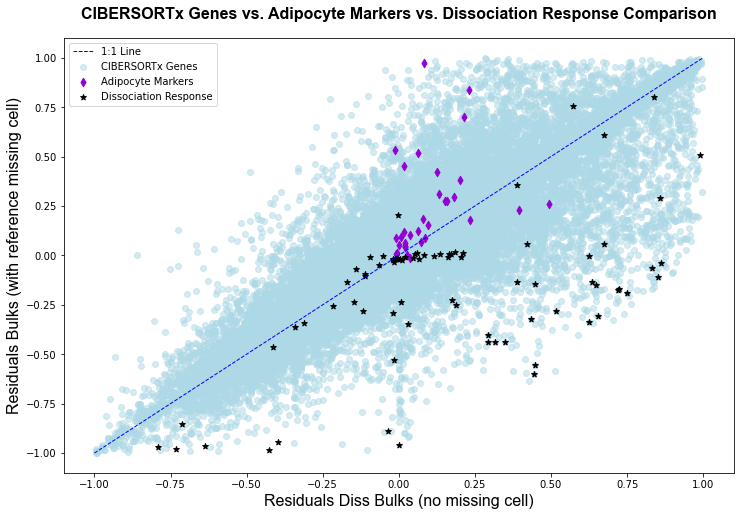

In [43]:
# Create a scatter plot with labels for multiple genes
plt.figure(figsize=(12, 8))

# Plot CIBERSORT genes
genes_of_interest = cibersort_genes
for gene in genes_of_interest:
    gene_data_bulks = residuals_bulks[gene]
    gene_data_dissbulks = residuals_dissbulks[gene]
    plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=0.5, c='lightblue', label='CIBERSORTx Genes' if gene == genes_of_interest[0] else "")

# Plot Adipocyte markers
for gene in adip_markers:
    gene_data_bulks = residuals_bulks[gene]
    gene_data_dissbulks = residuals_dissbulks[gene]
    plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=1, c='darkviolet', marker='d', label='Adipocyte Markers' if gene == adip_markers[0] else "")

# Plot Dissociation Response genes
for gene in diss_response:
    gene_data_bulks = residuals_bulks[gene]
    gene_data_dissbulks = residuals_dissbulks[gene]
    plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=1, c='black', marker='*', label='Dissociation Response' if gene == diss_response[0] else "")

# Plot 1:1 Line
plt.plot([-1, 1], [-1, 1], label='1:1 Line', color='blue', linewidth=1, linestyle='--')

# Set axis labels and title
plt.title('CIBERSORTx Genes vs. Adipocyte Markers vs. Dissociation Response Comparison', fontsize=16, fontname='Arial', fontweight='bold', x=0.5, y=1.03)
plt.ylabel('Residuals Bulks (with reference missing cell)', fontsize=16, fontname='Arial')
plt.xlabel('Residuals Diss Bulks (no missing cell)', fontsize=16, fontname='Arial')

# Add legend
plt.legend()

# Show the plot
plt.show()

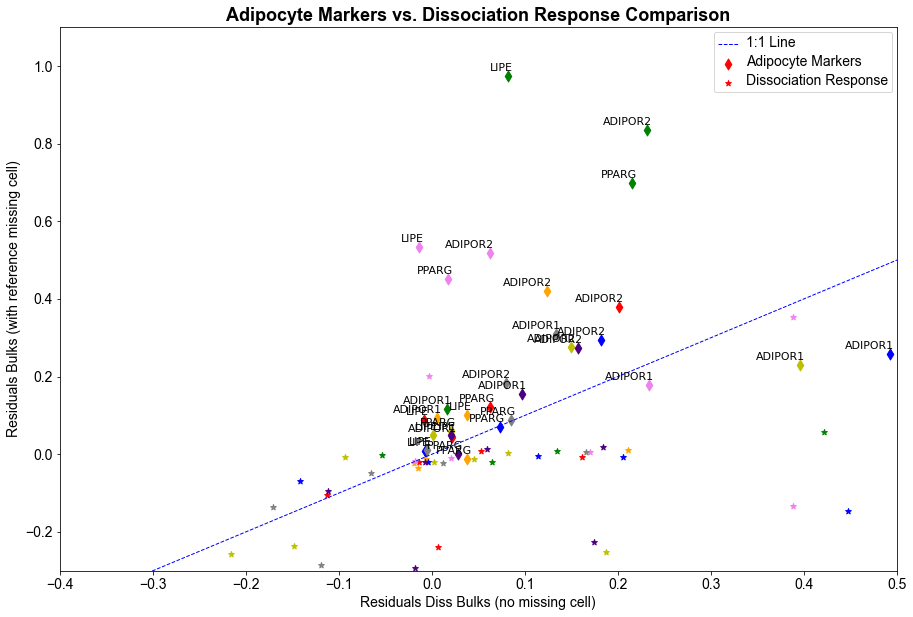

In [44]:

# Assuming `row_indices` contains the row indices of your samples
row_indices = np.tile(range(1, 9), 2)

# Define custom colors
custom_colors = ['r', 'orange', 'y', 'g', 'b', 'indigo', 'violet', 'grey']

# Create a custom colormap
cmap_custom = mcolors.ListedColormap(custom_colors)
marker_size = 100

# Create a scatter plot with labels for multiple genes
plt.figure(figsize=(15, 10))

# Get unique colors for each sample using the previously defined custom colormap
unique_colors = mcolors.ListedColormap(custom_colors)(np.arange(len(residuals_bulks)))

# Plot each gene for both bulks and dissbulks
for sample_idx, sample_color in enumerate(unique_colors):

    # Plot Adipocyte markers
    for gene in adip_markers:
        gene_data_bulks = residuals_bulks.at[sample_idx, gene]
        gene_data_dissbulks = residuals_dissbulks.at[sample_idx, gene]
        marker_size = 60  # Increase size for the first Adipocyte marker
        plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=1, c=[sample_color], marker='d', s=marker_size,
                    label='Adipocyte Markers' if gene == adip_markers[0] and sample_idx == 0 else "")
        plt.annotate(str(gene), (gene_data_dissbulks, gene_data_bulks), textcoords="offset points", xytext=(5, 5),
                     ha='right', fontsize=11)

    # Plot Dissociation Response genes
    for gene in diss_response:
        gene_data_bulks = residuals_bulks.at[sample_idx, gene]
        gene_data_dissbulks = residuals_dissbulks.at[sample_idx, gene]
        plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=1, c=[sample_color], marker='*',
                    label='Dissociation Response' if gene == diss_response[0] and sample_idx == 0 else "")

# Plot 1:1 Line
plt.plot([-1, 1], [-1, 1], label='1:1 Line', color='blue', linewidth=1, linestyle='--')

# Set axis labels and title
plt.title('Adipocyte Markers vs. Dissociation Response Comparison', fontsize=18, fontname='Arial', fontweight='bold')
plt.ylabel('Residuals Bulks (with reference missing cell)', fontsize=14, fontname='Arial')
plt.xlabel('Residuals Diss Bulks (no missing cell)', fontsize=14, fontname='Arial')

# Add legend
legend = plt.legend()
plt.xlim(-0.4, 0.5)
plt.ylim(-0.3, 1.1)

# Set font size and font family for legend
for text in legend.get_texts():
    text.set_fontsize(14)
    text.set_fontname('Arial')

# Set font size for tick labels
plt.xticks(fontsize=14, fontname='Arial')
plt.yticks(fontsize=14, fontname='Arial')

# Show the plot
plt.show()


# Distributions of Residuals

Classic (-rRNA) Bulks and Dissociated (-rRNA) Bulks

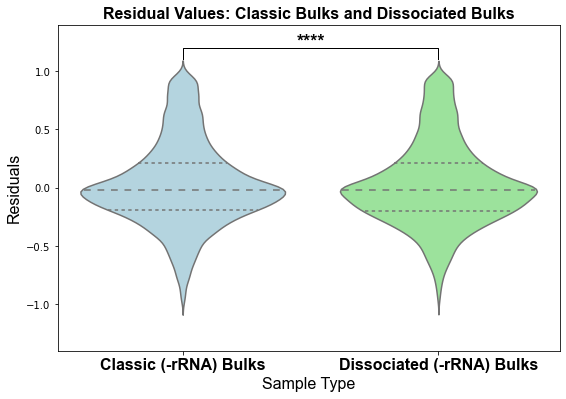

In [45]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
classic_bulks_values = residuals_bulks.values.flatten()
dissociated_bulks_values = residuals_dissbulks.values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(classic_bulks_values) +
                                  ['Dissociated Bulks'] * len(dissociated_bulks_values),
                   'Residuals': np.concatenate([classic_bulks_values, dissociated_bulks_values])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightgreen'])

# Add labels to the x-axis
ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, fontweight='bold', fontname='Arial')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(classic_bulks_values, dissociated_bulks_values)

# Set a significance level (e.g., 0.05)
alpha = 0.05

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.1, 1.2
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-0.03, asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value)} (p < 0.05)"
    # No asterisks for non-significant results

# Add the significance label and the name of the statistical test to the plot
#plt.text(0.5, .65, f'Wilcoxon T-Test: {significance_label}', fontsize=12, fontweight='bold', fontname='Arial')

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals', fontsize=16, fontname='Arial')
plt.title('Residual Values: Classic Bulks and Dissociated Bulks', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.4)
plt.show()


Dissociated (polyA) Bulks and Dissociated (-rRNA) Bulks

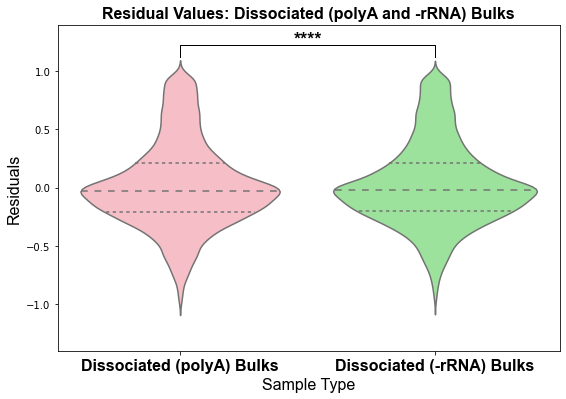

In [46]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
classic_bulks_values = residuals_disspolyabulks.values.flatten()
dissociated_bulks_values = residuals_dissbulks.values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(classic_bulks_values) +
                                  ['Dissociated Bulks'] * len(dissociated_bulks_values),
                   'Residuals': np.concatenate([classic_bulks_values, dissociated_bulks_values])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals', data=df, ax=ax, inner='quartile', palette=['lightpink', 'lightgreen'])

# Add labels to the x-axis
ax.set_xticklabels(['Dissociated (polyA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, fontname='Arial', fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(classic_bulks_values, dissociated_bulks_values)

# Set a significance level (e.g., 0.05)
alpha = 0.05

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.12, 1.22  # Adjusted higher y-coordinate
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-0.03, asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value)} (p < 0.05)"
    # No asterisks for non-significant results

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals', fontsize=16, fontname='Arial')
plt.title('Residual Values: Dissociated (polyA and -rRNA) Bulks', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.4)
plt.show()


**Distributions: Only Adipocyte Markers**

Classic (-rRNA) Bulks and Dissociated (-rRNA) Bulks

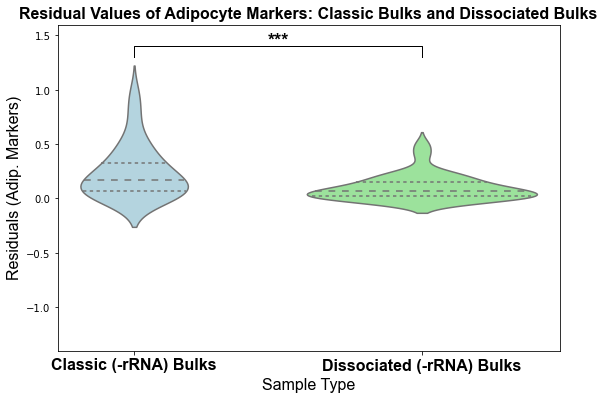

In [47]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
adip_intersect = np.intersect1d(residuals_bulks.columns, adip_markers)

classic_bulks_values = residuals_bulks[adip_intersect].values.flatten()
dissociated_bulks_values = residuals_dissbulks[adip_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(classic_bulks_values) +
                                  ['Dissociated Bulks'] * len(dissociated_bulks_values),
                   'Residuals (Adip. Markers)': np.concatenate([classic_bulks_values, dissociated_bulks_values])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (Adip. Markers)', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightgreen'])

# Add labels to the x-axis
ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, fontname='Arial', fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(classic_bulks_values, dissociated_bulks_values)

# Set a significance level (e.g., 0.05)
alpha = 0.05

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.3, 1.4  # Adjusted higher y-coordinate
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-0.03, asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)} (p < 0.05)"
    y1, y2 = 1.3, 1.4  # Adjusted higher y-coordinate
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2+0.03, "N.S.", ha='center', va='bottom', fontsize=14, fontname='Arial')

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Adip. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Adipocyte Markers: Classic Bulks and Dissociated Bulks', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.6)
plt.show()


Dissociated (-rRNA) Bulks and Dissociated (polyA) Bulks

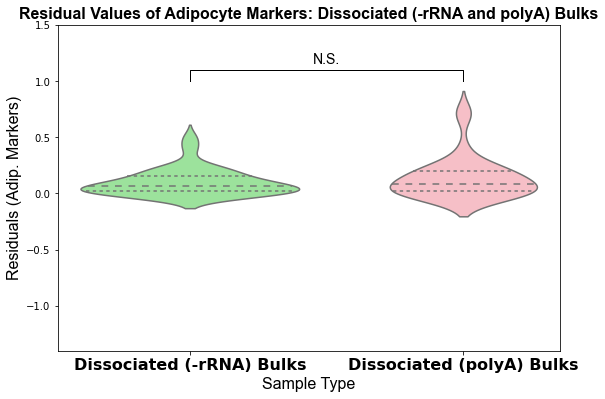

In [48]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
adip_intersect = np.intersect1d(residuals_bulks.columns, adip_markers)

classic_bulks_values = residuals_dissbulks[adip_intersect].values.flatten()
dissociated_bulks_values = residuals_disspolyabulks[adip_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(classic_bulks_values) +
                                  ['Dissociated Bulks'] * len(dissociated_bulks_values),
                   'Residuals (Adip. Markers)': np.concatenate([classic_bulks_values, dissociated_bulks_values])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (Adip. Markers)', data=df, ax=ax, inner='quartile', palette=['lightgreen', 'lightpink'])

# Add labels to the x-axis
ax.set_xticklabels(['Dissociated (-rRNA) Bulks', 'Dissociated (polyA) Bulks'], fontsize=16, fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(classic_bulks_values, dissociated_bulks_values)

# Set a significance level (e.g., 0.05)
alpha = 0.05

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.2, 1.3  # Adjusted higher y-coordinate
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2+0.03, asterisks, ha='center', va='bottom', fontsize=18,  fontname='Arial', fontweight='bold')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1,1.1
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2+0.03, 'N.S.', ha='center', va='bottom', fontsize=14,  fontname='Arial')
    # No asterisks for non-significant results

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Adip. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Adipocyte Markers: Dissociated (-rRNA and polyA) Bulks', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.5)
plt.show()


Classic (-rRNA) Bulks and Dissociated (polyA) Bulks

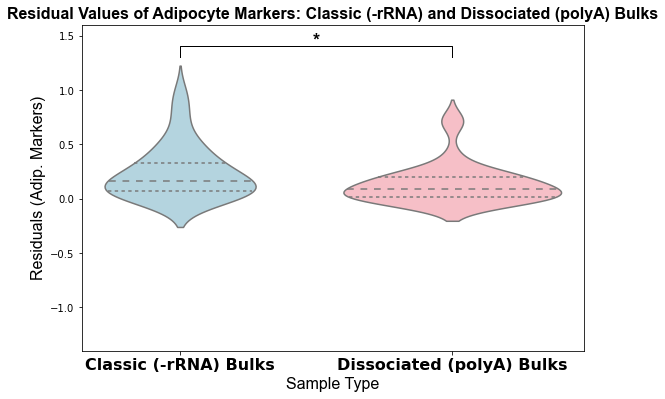

In [49]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
adip_intersect = np.intersect1d(residuals_bulks.columns, adip_markers)

classic_bulks_values = residuals_bulks[adip_intersect].values.flatten()
dissociated_bulks_values = residuals_disspolyabulks[adip_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(classic_bulks_values) +
                                  ['Dissociated Bulks'] * len(dissociated_bulks_values),
                   'Residuals (Adip. Markers)': np.concatenate([classic_bulks_values, dissociated_bulks_values])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (Adip. Markers)', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightpink'])

# Add labels to the x-axis
ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (polyA) Bulks'], fontsize=16, fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(classic_bulks_values, dissociated_bulks_values)

# Set a significance level (e.g., 0.05)
alpha = 0.05

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.3, 1.4 # Adjusted higher y-coordinate
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, (x1 + x2) / 2, x2, x2], [y1, y2, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-0.03 , asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.3, 1.4 # Adjusted higher y-coordinate
    # Add a line and asterisks to indicate statistical significance
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2+0.03, 'N.S.', ha='center', va='bottom', fontsize=14,  fontname='Arial')

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Adip. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Adipocyte Markers: Classic (-rRNA) and Dissociated (polyA) Bulks', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.6)
plt.show()

**Distributions: Only Dissociation Markers**

Classic (-rRNA) Bulks and Dissociated (-rRNA) Bulks

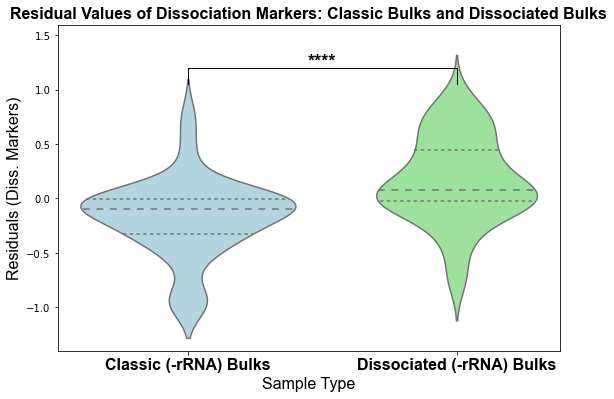

In [50]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
adip_intersect = np.intersect1d(residuals_bulks.columns, diss_response)

classic_bulks_values = residuals_bulks[adip_intersect].values.flatten()
dissociated_bulks_values = residuals_dissbulks[adip_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(classic_bulks_values) +
                                  ['Dissociated Bulks'] * len(dissociated_bulks_values),
                   'Residuals (Diss. Markers)': np.concatenate([classic_bulks_values, dissociated_bulks_values])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (Diss. Markers)', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightgreen'])

# Add labels to the x-axis
ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, fontname='Arial', fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(classic_bulks_values, dissociated_bulks_values)

# Set a significance level (e.g., 0.05)
alpha = 0.05

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.05, 1.2  # Adjusted higher y-coordinate
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-0.03, asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)} (p < 0.05)"
    x1, x2 = 0, 1
    y1, y2 = 1.05, 1.2  # Adjusted higher y-coordinate
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2+0.03, 'N.S.', ha='center', va='bottom', fontsize=14,  fontname='Arial')

# Add the significance label and the name of the statistical test to the plot
#plt.text(0.2, 0.9, f'Wilcoxon T-Test: {significance_label}', fontsize=12, fontweight='bold', fontname='Arial')

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Diss. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Dissociation Markers: Classic Bulks and Dissociated Bulks', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.6)
plt.show()


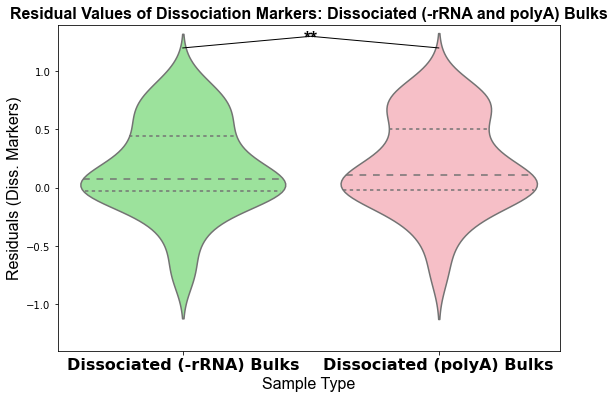

In [51]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
diss_res = np.intersect1d(residuals_bulks.columns, diss_response)

classic_bulks_values = residuals_dissbulks[diss_res].values.flatten()
dissociated_bulks_values = residuals_disspolyabulks[diss_res].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(classic_bulks_values) +
                                  ['Dissociated Bulks'] * len(dissociated_bulks_values),
                   'Residuals (Adip. Markers)': np.concatenate([classic_bulks_values, dissociated_bulks_values])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (Adip. Markers)', data=df, ax=ax, inner='quartile', palette=['lightgreen', 'lightpink'])

# Add labels to the x-axis
ax.set_xticklabels(['Dissociated (-rRNA) Bulks', 'Dissociated (polyA) Bulks'], fontsize=16, fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(classic_bulks_values, dissociated_bulks_values)

# Set a significance level (e.g., 0.05)
alpha = 0.05

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.2, 1.2  # Adjusted higher y-coordinate
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, (x1 + x2) / 2, x2, x2], [y1, y2, y2 + 0.1, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2 , asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.1,1.2
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Diss. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Dissociation Markers: Dissociated (-rRNA and polyA) Bulks', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.4)
plt.show()

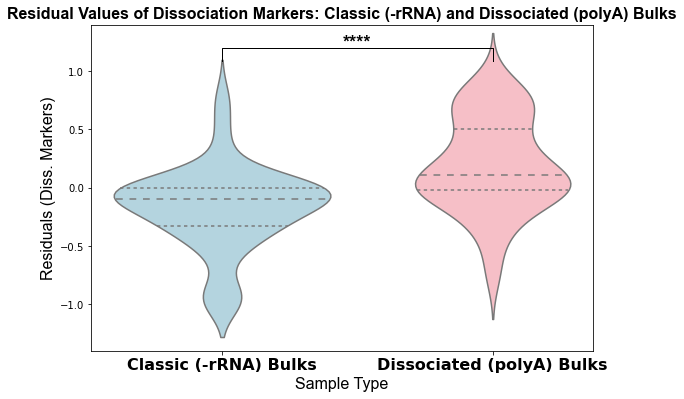

In [52]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
diss_mark = np.intersect1d(residuals_bulks.columns, diss_response)

classic_bulks_values = residuals_bulks[diss_mark].values.flatten()
dissociated_bulks_values = residuals_disspolyabulks[diss_mark].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(classic_bulks_values) +
                                  ['Dissociated Bulks'] * len(dissociated_bulks_values),
                   'Residuals (Diss. Markers)': np.concatenate([classic_bulks_values, dissociated_bulks_values])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (Diss. Markers)', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightpink'])

# Add labels to the x-axis
ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (polyA) Bulks'], fontsize=16, fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(classic_bulks_values, dissociated_bulks_values)

# Set a significance level (e.g., 0.05)
alpha = 0.05

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.09, 1.2 # Adjusted higher y-coordinate
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, (x1 + x2) / 2, x2, x2], [y1, y2, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-0.03 , asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1, 1.1
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Diss. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Dissociation Markers: Classic (-rRNA) and Dissociated (polyA) Bulks', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.4)
plt.show()

## PCA

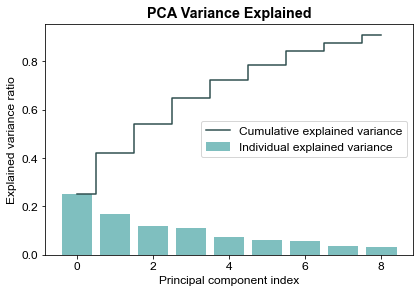

In [53]:

# Set font to Arial
font = {'family': 'Arial', 'weight': 'normal', 'size': 12}
plt.rc('font', **font)

pca_res = dict()
df = residuals_combo  # transposing to get length of genes instead of samples
fit = PCA(n_components=9)
pca_results = fit.fit_transform(df.values)

exp_var_pca = fit.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Plot variance explained
plt.bar(range(0, len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', color='teal', label='Individual explained variance')
plt.step(range(0, len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid', color='darkslategrey', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.title("PCA Variance Explained", fontweight='bold')
plt.show()


In [54]:
# Separate the first and last 8 samples
first_half_samples = pca_results[:8]
second_half_samples = pca_results[-8:]

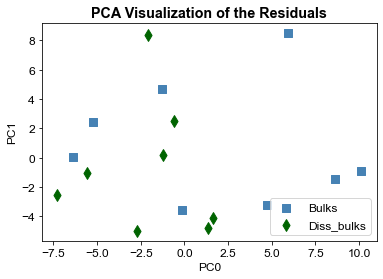

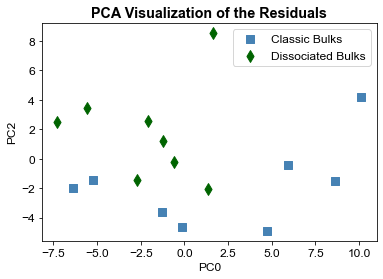

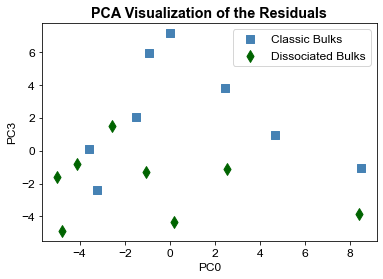

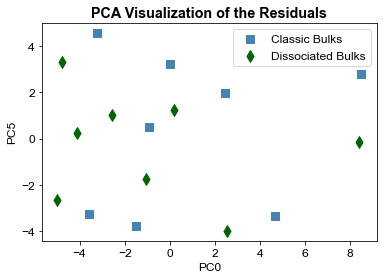

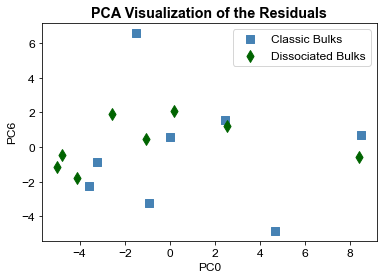

In [55]:
marker_size = 70

# Set font to Arial
font = {'family': 'Arial', 'weight': 'normal', 'size': 12}
plt.rc('font', **font)

# PCA Visualization of the Residuals
plt.scatter(first_half_samples[:, 0], first_half_samples[:, 1], label="Bulks", c='steelblue', marker='s', s=marker_size)
plt.scatter(second_half_samples[:, 0], second_half_samples[:, 1], label="Diss_bulks", c='darkgreen', marker='d', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC1")
plt.show()

# PCA Visualization
plt.scatter(first_half_samples[:, 0], first_half_samples[:, 2], label="Classic Bulks", c='steelblue', marker='s', s=marker_size)
plt.scatter(second_half_samples[:, 0], second_half_samples[:, 2], label="Dissociated Bulks", c='darkgreen', marker='d', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC2")
plt.show()

# PCA Visualization
plt.scatter(first_half_samples[:, 1], first_half_samples[:, 3], label="Classic Bulks", c='steelblue', marker='s', s=marker_size)
plt.scatter(second_half_samples[:, 1], second_half_samples[:, 3], label="Dissociated Bulks", c='darkgreen', marker='d', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC3")
plt.show()

# PCA Visualization
plt.scatter(first_half_samples[:, 1], first_half_samples[:, 4], label="Classic Bulks", c='steelblue', marker='s', s=marker_size)
plt.scatter(second_half_samples[:, 1], second_half_samples[:, 4], label="Dissociated Bulks", c='darkgreen', marker='d', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC5")
plt.show()

# PCA Visualization
plt.scatter(first_half_samples[:, 1], first_half_samples[:, 5], label="Classic Bulks", c='steelblue', marker='s', s=marker_size)
plt.scatter(second_half_samples[:, 1], second_half_samples[:, 5], label="Dissociated Bulks", c='darkgreen', marker='d', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC6")
plt.show()



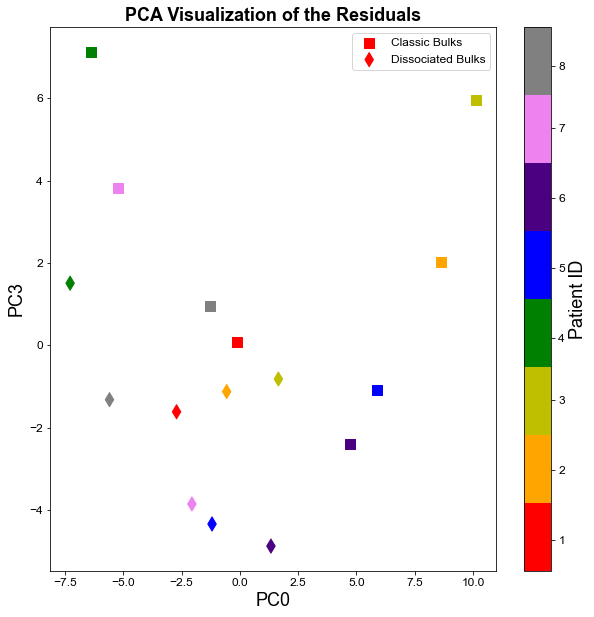

In [94]:
# Assuming `row_indices` contains the row indices of your samples
row_indices = np.tile(range(1, 9), 2)
plt.figure(figsize = (10,10))
# Define custom colors
custom_colors = ['r', 'orange', 'y', 'g', 'b', 'indigo', 'violet', 'grey']

# Create a custom colormap
cmap_custom = mcolors.ListedColormap(custom_colors)
marker_size = 100

# PCA Visualization
scatter1 = plt.scatter(first_half_samples[:, 0], first_half_samples[:, 3], label="Classic Bulks", c=row_indices[:len(first_half_samples)], 
                            cmap=cmap_custom, marker='s', s=marker_size)
scatter2 = plt.scatter(second_half_samples[:, 0], second_half_samples[:, 3], label="Dissociated Bulks", c=row_indices[len(first_half_samples):], 
                            cmap=cmap_custom, marker='d', s=marker_size)

# Add colorbar for reference
cbar = plt.colorbar()
cbar.set_label('Patient ID', fontsize=18)

# Adjust colorbar ticks to be centered between colors
cbar.set_ticks([1.4, 2.3 ,3.2 ,4, 4.9 , 5.8 ,6.7 ,7.5])
cbar.set_ticklabels([1,2,3,4,5,6,7,8])

# Change the color of the little marker in the legend
# Change the color of the marker in the legend using a custom handler
legend = plt.legend()

plt.title("PCA Visualization of the Residuals", fontweight='bold', fontsize=18, fontname='Arial')
plt.xlabel("PC0", fontsize=18, fontname='Arial')
plt.ylabel("PC3", fontsize=18, fontname='Arial')
plt.show()


In [57]:
# 'residuals_all.columns' contains the names of the genes
comp_genes= []
pca_genes = dict()
# Perform PCA for up to 6 components
num_components = 9
pca = PCA(n_components=num_components)
principal_components = pca.fit_transform(residuals_combo)

# Iterate through each component
for component_idx in range(num_components):
    # Calculate loadings for the current component
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

    # Sort genes by their influence on the current component
    sorted_genes = residuals_combo.columns[np.argsort(loadings[:, component_idx])]

    # Visualize the top N genes that contribute the most to the current component
    N = 10  
    top_genes = sorted_genes[-N:]

    print(f"Genes contributing the most to Principal Component {component_idx + 1}:")
    print(top_genes)

    pca_genes[component_idx] = top_genes
    comp_genes = np.append(comp_genes, top_genes)


Genes contributing the most to Principal Component 1:
Index(['CDH1', 'CLDN7', 'SRGAP3', 'CRABP2', 'KLK8', 'DMKN', 'SMC4', 'KLK11',
       'FOLR1', 'SPINT2'],
      dtype='object')
Genes contributing the most to Principal Component 2:
Index(['CXCL9', 'FCGR3A', 'TYROBP', 'PLEK', 'FPR3', 'SAMD9L', 'LILRB4', 'FYB1',
       'GBP5', 'SIGLEC1'],
      dtype='object')
Genes contributing the most to Principal Component 3:
Index(['CSF3R', 'MUC1', 'TNF', 'TFPI2', 'ZBTB43', 'DUSP4', 'UPP1', 'NLRP3',
       'B3GNT5', 'RNF19B'],
      dtype='object')
Genes contributing the most to Principal Component 4:
Index(['SLC39A8', 'SLC19A2', 'PTX3', 'LIPE', 'IRAK3', 'GPX3', 'PDE3B',
       'TNFSF14', 'ANK2', 'USP53'],
      dtype='object')
Genes contributing the most to Principal Component 5:
Index(['HK2', 'PTGS2', 'EGFR', 'RDX', 'CKB', 'HMGA1', 'ANPEP', 'IGF2BP2',
       'LAMA2', 'FAM107A'],
      dtype='object')
Genes contributing the most to Principal Component 6:
Index(['PRKX', 'PLEKHG1', 'UVRAG', 'TACSTD

In [58]:
int_adip =[]
int_eryth = []
int_diss = []
for component in pca_genes:
    for gene in pca_genes[component]:
        if gene in adip_markers:    
            print(f"{gene} adip")
            print(component)  
        if gene in diss_response:
            print(f"{gene} dissociation") 
            print(component)      

LIPE adip
3


## NMF

Analyzing how close to negative the distributions of each residual are:

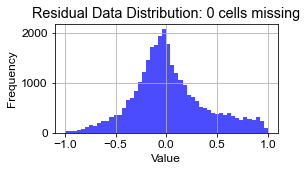

In [59]:
data = residuals_bulks.values
num=0
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

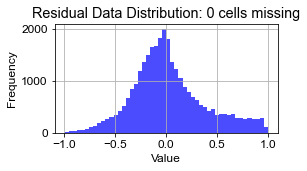

In [60]:
data = residuals_dissbulks.values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Shifting distributions according to above plots, and calculating NMF:

0.9988651323255705


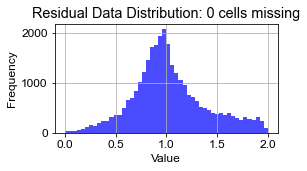

In [61]:
residuals_bulks_shift=residuals_bulks
if nmf_cut == "minimum_value":
    #calculate value to shift distributions minimally:
    min_val = abs(np.min(np.min(residuals_bulks)))
    print(min_val)
    residuals_bulks_shift= residuals_bulks + min_val
elif nmf_cut == "at_0":
    #cutting distribution at 0
    residuals_bulks_shift[residuals_bulks_shift.values <= 0] = 0
data = residuals_bulks_shift.values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

0.9962078119074704


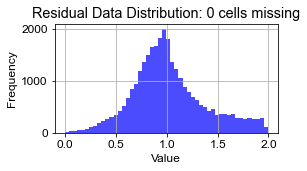

In [62]:
residuals_dissbulks_shift=residuals_dissbulks
if nmf_cut == "minimum_value":
    #calculate value to shift distributions minimally:
    min_val = abs(np.min(np.min(residuals_dissbulks)))
    print(min_val)
    residuals_dissbulks_shift= residuals_dissbulks + min_val
elif nmf_cut == "at_0":
    #cutting distribution at 0
    residuals_dissbulks_shift[residuals_dissbulks_shift.values <= 0] = 0
data = residuals_dissbulks_shift.values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

0.9988651323255705


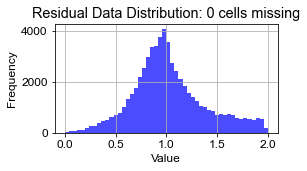

In [63]:
residuals_combo_shift=residuals_combo
if nmf_cut == "minimum_value":
    #calculate value to shift distributions minimcomboy:
    min_val = abs(np.min(np.min(residuals_combo)))
    print(min_val)
    residuals_combo_shift= residuals_combo + min_val
elif nmf_cut == "at_0":
    #cutting distribution at 0
    residuals_combo_shift[residuals_combo_shift.values <= 0] = 0
data = residuals_combo_shift.values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

The combined residuals (classic and dissociated)

In [64]:
#nmf on residual 1
num_nmf_comp_combo = 4
nmf = NMF(n_components = num_nmf_comp_combo, init='nndsvd', max_iter=20000)
res_nmf_df = nmf.fit_transform(residuals_combo_shift)
res_nmf_df = pd.DataFrame(res_nmf_df)
res_nmf_combo = res_nmf_df
components_combo = pd.DataFrame(nmf.components_)
components_combo.columns = gene_ids
components_combo

,A1BG,A2M,AAMDC,ABCA1,ABCB1,ABCB8,ABCC1,ABCE1,ABHD12,ABHD14B,...,ZNHIT3,ZNHIT6,ZNRD2,ZNRF2,ZPR1,ZRANB1,ZRSR2,ZSWIM6,ZYX,ZZEF1
0,0.089570,0.255009,0.130832,0.216520,0.140860,0.161916,0.142555,0.150564,0.106081,0.115781,...,0.119473,0.149088,0.098387,0.105542,0.160927,0.132376,0.081340,0.102478,0.220381,0.185975
1,0.075371,0.206800,0.105708,0.177718,0.097344,0.139335,0.149150,0.111576,0.149586,0.095242,...,0.100050,0.100566,0.079428,0.084532,0.123480,0.103220,0.064522,0.092391,0.099290,0.169874
2,0.074172,0.220274,0.105746,0.186096,0.119214,0.122387,0.123048,0.153741,0.152689,0.093414,...,0.105962,0.104397,0.082115,0.078205,0.111472,0.089804,0.074552,0.101122,0.190442,0.223862
3,0.071784,0.226072,0.107244,0.205195,0.087939,0.117842,0.112654,0.104380,0.145427,0.096708,...,0.087080,0.074246,0.084195,0.089182,0.224053,0.117259,0.051195,0.073681,0.171503,0.133597


In [65]:
# Separate the data into "classic bulks" and "dissociated bulks"
df = res_nmf_combo
classic_bulks = df.iloc[:8, :]
dissociated_bulks = df.iloc[8:, :]

# Perform t-test for each component
results = pd.DataFrame(columns=['Component', 'T-Statistic', 'P-Value'])

for column in df.columns:
    t_statistic, p_value = stats.ttest_ind(classic_bulks[column], dissociated_bulks[column])
    results = results.append({'Component': column, 'T-Statistic': t_statistic, 'P-Value': p_value}, ignore_index=True)

# Print the results
print(results)

# Identify components with significantly different means
significantly_different = results[results['P-Value'] < 0.05]
print("Components with significantly different means:")
print(significantly_different)

   Component  T-Statistic   P-Value
0        0.0     0.641368  0.531644
1        1.0     1.482507  0.160364
2        2.0     0.037840  0.970350
3        3.0    -5.583431  0.000067
Components with significantly different means:
   Component  T-Statistic   P-Value
3        3.0    -5.583431  0.000067


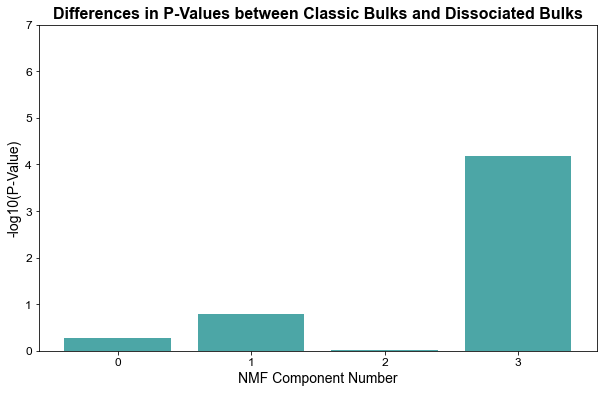

In [66]:
# Bar plot for each component
plt.figure(figsize=(10, 6))
plt.bar(results['Component'], -np.log10(results['P-Value']), color='teal', alpha=0.7)

plt.xlabel('NMF Component Number', fontsize=14, fontname='Arial')
plt.ylabel('-log10(P-Value)', fontsize=14, fontname='Arial')
plt.title('Differences in P-Values between Classic Bulks and Dissociated Bulks', fontsize=16, fontname='Arial', fontweight='bold')
plt.xticks([0,1,2,3])
plt.ylim(0,7)
plt.show()

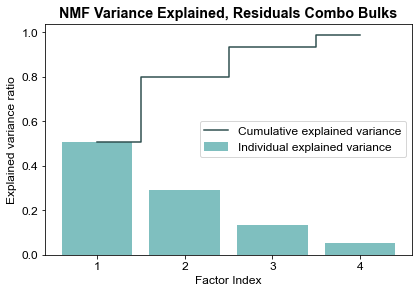

In [67]:
# W and H are your NMF results
V = residuals_combo_shift.values
W = res_nmf_combo.values
H = components_combo.values # Solve for H using least squares

# Calculate the explained variance for each component
explained_variance = []
for i in range(W.shape[1]):
    WH = np.dot(W[:, :i+1], H[:i+1, :])
    explained_variance.append(1 - np.linalg.norm(V - WH, 'fro')**2 / np.linalg.norm(V, 'fro')**2)

cum_sum = explained_variance

indiv_variance =  [cum_sum[0], 
                cum_sum[1] - cum_sum[0],
                cum_sum[2]- cum_sum[1],
                cum_sum[3] - cum_sum[2]]
#                cum_sum[4] - cum_sum[3] ]



## plot variance explained
plt.bar(range(1,len(indiv_variance)+1), indiv_variance, alpha=0.5, align='center', label='Individual explained variance',color='teal')
plt.step(range(1,len(cum_sum)+1), cum_sum, where='mid',label='Cumulative explained variance', color='darkslategrey')
plt.ylabel('Explained variance ratio', fontname="Arial")
plt.xlabel('Factor Index', fontname="Arial")
plt.legend(loc='best')
plt.tight_layout()
plt.xticks(range(1,len(res_nmf_combo.columns)+1))
plt.title(f"NMF Variance Explained, Residuals Combo Bulks", fontweight='bold', fontname="Arial")
plt.show()

In [68]:
W = res_nmf_combo.values
H = components_combo.values

comp_genes = dict()
num_components = num_nmf_comp_combo
# Iterate through each component
for component_idx in range(num_components):
    # Sort genes by their influence on the current component
    sorted_genes = residuals_combo.columns[np.argsort(H[component_idx])]

    # Visualize the top N genes that contribute the most to the current component
    N = 10
    top_genes = sorted_genes[-N:]

    print(f"Genes contributing the most to NMF Component {component_idx + 1}:")
    print(top_genes)
 
    comp_genes[component_idx] =top_genes

Genes contributing the most to NMF Component 1:
Index(['MYH10', 'FBLN2', 'SEMA3C', 'COL14A1', 'PARVA', 'PHLDB1', 'DDR2',
       'AKAP12', 'CYBRD1', 'PTGIS'],
      dtype='object')
Genes contributing the most to NMF Component 2:
Index(['CLDN7', 'MEIS1', 'MECOM', 'JUP', 'FOLR1', 'CP', 'SLC34A2', 'ITGB8',
       'PAX8', 'CDH1'],
      dtype='object')
Genes contributing the most to NMF Component 3:
Index(['DMXL2', 'ITGAX', 'DDX60L', 'GBP5', 'LILRB4', 'MSR1', 'FPR3', 'FCGR3A',
       'OAS2', 'SIGLEC1'],
      dtype='object')
Genes contributing the most to NMF Component 4:
Index(['ITPRIP', 'CXCL8', 'RNF19B', 'KLF4', 'PLK2', 'ADAMTS4', 'B3GNT5',
       'KRT17', 'NLRP3', 'KLHL21'],
      dtype='object')


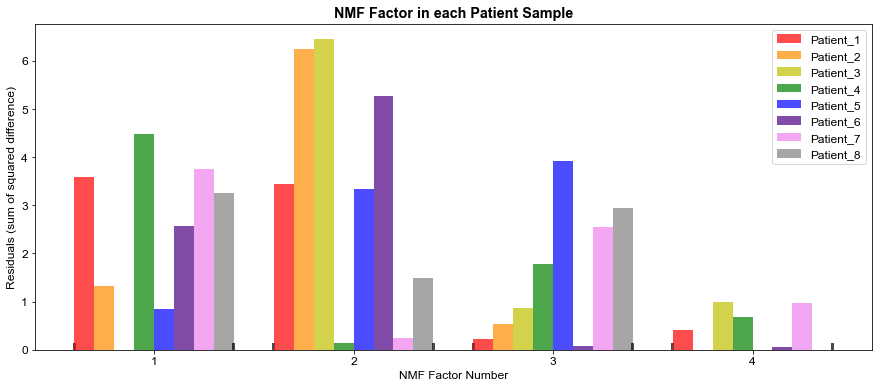

In [69]:
pt1_values = res_nmf_combo.loc[0].values
pt2_values = res_nmf_combo.loc[1].values
pt3_values = res_nmf_combo.loc[2].values
pt4_values = res_nmf_combo.loc[3].values
pt5_values = res_nmf_combo.loc[4].values
pt6_values = res_nmf_combo.loc[5].values
pt7_values = res_nmf_combo.loc[6].values
pt8_values = res_nmf_combo.loc[7].values

# Define custom colors
custom_colors = ['r', 'darkorange', 'y', 'g', 'b', 'indigo', 'violet', 'grey']

# Create x-coordinates for the bars
x_coordinates = np.arange(len(pt1_values)) + 1

# Width of each bar
bar_width = 0.1

# Set the font to Arial for all text
plt.rcParams['font.family'] = 'Arial'

plt.figure(figsize=(15, 6))

# Plot "Classic Bulks" residuals
plt.bar(x_coordinates - (bar_width * 4), 0.15, width=0.015, alpha=0.7, color='black')
plt.bar(x_coordinates - (bar_width * 3.5), pt1_values, width=bar_width, alpha=0.7, label='Patient_1', color=custom_colors[0])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates - (bar_width * 2.5), pt2_values, width=bar_width, alpha=0.7, label='Patient_2', color=custom_colors[1])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates - (bar_width * 1.5), pt3_values, width=bar_width, alpha=0.7, label='Patient_3', color=custom_colors[2])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates - (bar_width * 0.5), pt4_values, width=bar_width, alpha=0.7, label='Patient_4', color=custom_colors[3])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + (bar_width * 0.5), pt5_values, width=bar_width, alpha=0.7, label='Patient_5', color=custom_colors[4])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + (bar_width * 1.5), pt6_values, width=bar_width, alpha=0.7, label='Patient_6', color=custom_colors[5])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + (bar_width * 2.5), pt7_values, width=bar_width, alpha=0.7, label='Patient_7', color=custom_colors[6])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + (bar_width * 3.5), pt8_values, width=bar_width, alpha=0.7, label='Patient_8', color=custom_colors[7])
plt.bar(x_coordinates + (bar_width * 4), 0.15, width=0.015, alpha=0.7, color='black')
plt.xlabel('NMF Factor Number')
plt.ylabel('Residuals (sum of squared difference)')

# Set the title to bold
plt.title('NMF Factor in each Patient Sample', fontweight='bold')

plt.xticks(x_coordinates)  # Adjust x-axis labels

# Move the legend to the upper right corner
plt.legend()

plt.show()

Now dissociated bulks:

In [70]:
#nmf on residual 1
num_nmf = 5
nmf = NMF(n_components = num_nmf, init="nndsvd", max_iter=10000)
res_nmf_df = nmf.fit_transform(residuals_dissbulks_shift)
res_nmf_df = pd.DataFrame(res_nmf_df)
res_nmf_dissbulks = res_nmf_df
components_dissbulks = pd.DataFrame(nmf.components_)
components_dissbulks.columns = gene_ids
components_dissbulks

,A1BG,A2M,AAMDC,ABCA1,ABCB1,ABCB8,ABCC1,ABCE1,ABHD12,ABHD14B,...,ZNHIT3,ZNHIT6,ZNRD2,ZNRF2,ZPR1,ZRANB1,ZRSR2,ZSWIM6,ZYX,ZZEF1
0,0.088086,0.245576,0.122260,0.209227,0.118494,0.158476,0.139283,0.125461,0.151024,0.105329,...,0.115791,0.125697,0.102869,0.101803,0.188388,0.119812,0.077856,0.098793,0.188562,0.169510
1,0.040414,0.104880,0.055015,0.088582,0.068235,0.073724,0.056568,0.059721,0.067985,0.035199,...,0.051898,0.054454,0.042450,0.035531,0.053196,0.048953,0.033376,0.044841,0.092047,0.093044
2,0.052404,0.169071,0.085566,0.151084,0.085198,0.095109,0.092290,0.097160,0.074559,0.075838,...,0.071882,0.077065,0.055083,0.067111,0.105161,0.087056,0.045641,0.072352,0.141509,0.124122
3,0.051528,0.156694,0.072927,0.140470,0.056985,0.082808,0.089797,0.082121,0.115744,0.064235,...,0.060532,0.049845,0.055014,0.054926,0.125830,0.077413,0.031783,0.047624,0.073966,0.115733
4,0.056521,0.190368,0.089215,0.167913,0.069439,0.089778,0.115494,0.115338,0.122269,0.114414,...,0.082034,0.080725,0.069036,0.087427,0.174258,0.090433,0.066638,0.065347,0.173584,0.145487


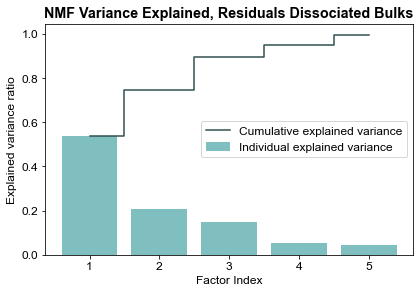

In [71]:
# W and H are your NMF results
V = residuals_dissbulks_shift.values
W = res_nmf_dissbulks.values
H = components_dissbulks.values # Solve for H using least squares

# Calculate the explained variance for each component
explained_variance = []
for i in range(W.shape[1]):
    WH = np.dot(W[:, :i+1], H[:i+1, :])
    explained_variance.append(1 - np.linalg.norm(V - WH, 'fro')**2 / np.linalg.norm(V, 'fro')**2)

cum_sum = explained_variance

indiv_variance =  [cum_sum[0], 
                cum_sum[1] - cum_sum[0],
                cum_sum[2]- cum_sum[1],
                cum_sum[3] - cum_sum[2],
                cum_sum[4] - cum_sum[3] ]



## plot variance explained
plt.bar(range(1,len(indiv_variance)+1), indiv_variance, alpha=0.5, align='center', label='Individual explained variance',color='teal')
plt.step(range(1,len(cum_sum)+1), cum_sum, where='mid',label='Cumulative explained variance', color='darkslategrey')
plt.ylabel('Explained variance ratio', fontname="Arial")
plt.xlabel('Factor Index', fontname="Arial")
plt.legend(loc='best')
plt.tight_layout()
plt.title(f"NMF Variance Explained, Residuals Dissociated Bulks", fontweight='bold', fontname="Arial")
plt.show()

In [72]:
num_components = 5
W = res_nmf_dissbulks.values
H = components_dissbulks.values

comp_genes = dict()

# Iterate through each component
for component_idx in range(num_components):
    # Sort genes by their influence on the current component
    sorted_genes = residuals_dissbulks.columns[np.argsort(H[component_idx])]

    # Visualize the top N genes that contribute the most to the current component
    N = 10
    top_genes = sorted_genes[-N:]

    print(f"Genes contributing the most to NMF Component {component_idx + 1}:")
    print(top_genes)
 
    comp_genes[component_idx] =top_genes

Genes contributing the most to NMF Component 1:
Index(['CDH1', 'FKBP9', 'MEIS1', 'ARHGAP29', 'PBX1', 'ENAH', 'TEAD1', 'MYO10',
       'PTK7', 'ITGB8'],
      dtype='object')
Genes contributing the most to NMF Component 2:
Index(['OLFML2B', 'SLC11A1', 'ARAP1', 'OLR1', 'FCGR3A', 'DEPP1', 'DDX60L',
       'PLXDC1', 'SLCO2B1', 'SIGLEC1'],
      dtype='object')
Genes contributing the most to NMF Component 3:
Index(['GFPT2', 'MAP1B', 'PLAT', 'CSF3', 'CYP1B1', 'S1PR1', 'LIFR', 'TINAGL1',
       'CXCL12', 'CD36'],
      dtype='object')
Genes contributing the most to NMF Component 4:
Index(['GPX3', 'ENPP2', 'KLK8', 'FOLR1', 'DEFB1', 'FAM107A', 'CRABP2', 'TFPI2',
       'B3GNT5', 'CSF3R'],
      dtype='object')
Genes contributing the most to NMF Component 5:
Index(['CCL2', 'FCN1', 'PPIF', 'KLHL21', 'HK2', 'CSF1', 'THBD', 'RNF19B',
       'PTGS2', 'IL6'],
      dtype='object')


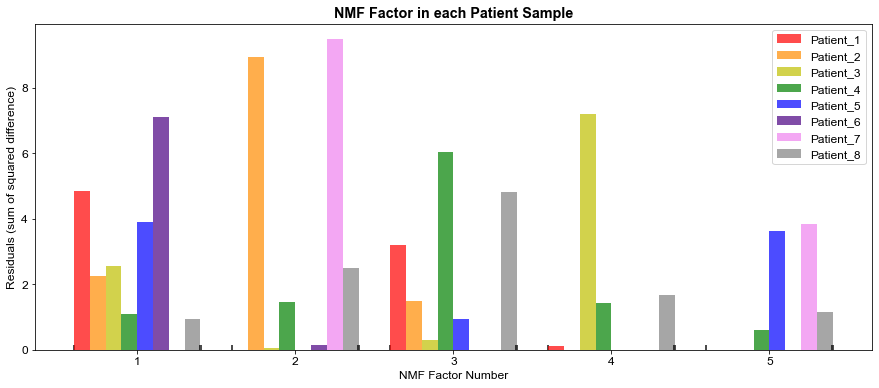

In [73]:
pt1_values = res_nmf_dissbulks.loc[0].values
pt2_values = res_nmf_dissbulks.loc[1].values
pt3_values = res_nmf_dissbulks.loc[2].values
pt4_values = res_nmf_dissbulks.loc[3].values
pt5_values = res_nmf_dissbulks.loc[4].values
pt6_values = res_nmf_dissbulks.loc[5].values
pt7_values = res_nmf_dissbulks.loc[6].values
pt8_values = res_nmf_dissbulks.loc[7].values

# Define custom colors
custom_colors = ['r', 'darkorange', 'y', 'g', 'b', 'indigo', 'violet', 'grey']

# Create x-coordinates for the bars
x_coordinates = np.arange(len(pt1_values)) + 1

# Width of each bar
bar_width = 0.1

# Set the font to Arial for all text
plt.rcParams['font.family'] = 'Arial'

plt.figure(figsize=(15, 6))

# Plot "Classic Bulks" residuals
plt.bar(x_coordinates - (bar_width * 4), 0.15, width=0.015, alpha=0.7, color='black')
plt.bar(x_coordinates - (bar_width * 3.5), pt1_values, width=bar_width, alpha=0.7, label='Patient_1', color=custom_colors[0])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates - (bar_width * 2.5), pt2_values, width=bar_width, alpha=0.7, label='Patient_2', color=custom_colors[1])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates - (bar_width * 1.5), pt3_values, width=bar_width, alpha=0.7, label='Patient_3', color=custom_colors[2])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates - (bar_width * 0.5), pt4_values, width=bar_width, alpha=0.7, label='Patient_4', color=custom_colors[3])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + (bar_width * 0.5), pt5_values, width=bar_width, alpha=0.7, label='Patient_5', color=custom_colors[4])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + (bar_width * 1.5), pt6_values, width=bar_width, alpha=0.7, label='Patient_6', color=custom_colors[5])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + (bar_width * 2.5), pt7_values, width=bar_width, alpha=0.7, label='Patient_7', color=custom_colors[6])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + (bar_width * 3.5), pt8_values, width=bar_width, alpha=0.7, label='Patient_8', color=custom_colors[7])
plt.bar(x_coordinates + (bar_width * 4), 0.15, width=0.015, alpha=0.7, color='black')
plt.xlabel('NMF Factor Number')
plt.ylabel('Residuals (sum of squared difference)')

# Set the title to bold
plt.title('NMF Factor in each Patient Sample', fontweight='bold')

plt.xticks(x_coordinates)  # Adjust x-axis labels

# Move the legend to the upper right corner
plt.legend()

plt.show()

And Classic Bulks

In [74]:
#NMF Residual(by sample) of bulks
num_nmf = 5
nmf = NMF(n_components = num_nmf, max_iter=10000, init="nndsvd")
res_nmf_df = nmf.fit_transform(residuals_bulks_shift)
components_bulks = nmf.components_
res_nmf_df = pd.DataFrame(res_nmf_df)
res_nmf_bulks = res_nmf_df
components_bulks = pd.DataFrame(components_bulks)
components_bulks.columns = gene_ids
components_bulks

,A1BG,A2M,AAMDC,ABCA1,ABCB1,ABCB8,ABCC1,ABCE1,ABHD12,ABHD14B,...,ZNHIT3,ZNHIT6,ZNRD2,ZNRF2,ZPR1,ZRANB1,ZRSR2,ZSWIM6,ZYX,ZZEF1
0,0.090505,0.246373,0.138564,0.216400,0.127060,0.177763,0.210226,0.158168,0.155904,0.130264,...,0.120280,0.128780,0.092329,0.106053,0.158641,0.125256,0.084532,0.113547,0.140043,0.196305
1,0.057019,0.165589,0.083028,0.139955,0.094094,0.091876,0.102366,0.124340,0.077037,0.081782,...,0.076057,0.090171,0.064138,0.064940,0.115159,0.084965,0.049564,0.073487,0.137362,0.139134
2,0.042632,0.136735,0.058099,0.114860,0.061678,0.067390,0.053527,0.088912,0.089541,0.046369,...,0.062721,0.060581,0.050489,0.046934,0.066603,0.048894,0.041978,0.060441,0.112631,0.128611
3,0.055397,0.160465,0.072962,0.134611,0.078970,0.084128,0.097439,0.090211,0.122132,0.071259,...,0.074766,0.068123,0.059796,0.059493,0.089066,0.085830,0.038733,0.080724,0.069873,0.151399
4,0.053028,0.152078,0.068841,0.127996,0.068753,0.096115,0.049203,0.039756,0.084780,0.048896,...,0.068065,0.079630,0.056856,0.059258,0.078171,0.078137,0.043839,0.042768,0.118155,0.108818


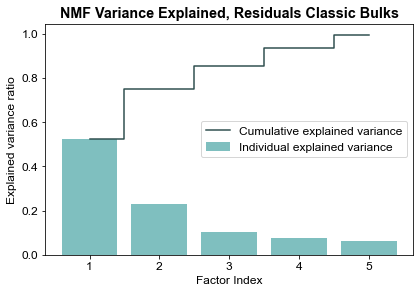

In [75]:
# W and H are your NMF results
V = residuals_bulks_shift.values
W = res_nmf_bulks.values
H = components_bulks.values # Solve for H using least squares

# Calculate the explained variance for each component
explained_variance = []
for i in range(W.shape[1]):
    WH = np.dot(W[:, :i+1], H[:i+1, :])
    explained_variance.append(1 - np.linalg.norm(V - WH, 'fro')**2 / np.linalg.norm(V, 'fro')**2)

cum_sum = explained_variance

indiv_variance =  [cum_sum[0], 
                cum_sum[1] - cum_sum[0],
                cum_sum[2]- cum_sum[1],
                cum_sum[3] - cum_sum[2],
                cum_sum[4] - cum_sum[3] ]


## plot variance explained
plt.bar(range(1,len(indiv_variance)+1), indiv_variance, alpha=0.5, align='center', label='Individual explained variance',color='teal')
plt.step(range(1,len(cum_sum)+1), cum_sum, where='mid',label='Cumulative explained variance', color='darkslategrey')
plt.ylabel('Explained variance ratio', fontname="Arial")
plt.xlabel('Factor Index', fontname="Arial")
plt.legend(loc='best')
plt.tight_layout()
plt.title(f"NMF Variance Explained, Residuals Classic Bulks", fontweight='bold', fontname="Arial")
plt.show()

In [76]:
num_components = 5
W = res_nmf_bulks.values
H = components_bulks.values

comp_genes = dict()

# Iterate through each component
for component_idx in range(0,5):
    # Sort genes by their influence on the current component
    sorted_genes = residuals_bulks.columns[np.argsort(H[component_idx])]

    # Visualize the top N genes that contribute the most to the current component
    N = 10
    top_genes = sorted_genes[-N:]

    print(f"Genes contributing the most to NMF Component {component_idx + 1}:")
    print(top_genes)
 
    comp_genes[component_idx] =top_genes

Genes contributing the most to NMF Component 1:
Index(['JUP', 'FOLR1', 'QSOX1', 'CFI', 'CDH1', 'LDLR', 'MECOM', 'MSLN',
       'ITGB8', 'DHCR24'],
      dtype='object')
Genes contributing the most to NMF Component 2:
Index(['MAP1B', 'CRISPLD2', 'ALDH1A3', 'CXCL12', 'CYP1B1', 'ADAMTS4', 'PTGIS',
       'FHL1', 'CD36', 'GFPT2'],
      dtype='object')
Genes contributing the most to NMF Component 3:
Index(['NCF2', 'CXCL9', 'FCGR3A', 'ITGAX', 'LYZ', 'FPR3', 'GBP5', 'MSR1',
       'LILRB4', 'SIGLEC1'],
      dtype='object')
Genes contributing the most to NMF Component 4:
Index(['PREX2', 'GPX3', 'INPP4B', 'EPHX1', 'PRSS23', 'TMOD1', 'CSF3R', 'ANK2',
       'GLI3', 'KIF26B'],
      dtype='object')
Genes contributing the most to NMF Component 5:
Index(['AKAP12', 'CYBRD1', 'F13A1', 'PDLIM3', 'LTBP1', 'BGN', 'HTRA1', 'CDH11',
       'MEG3', 'COL14A1'],
      dtype='object')


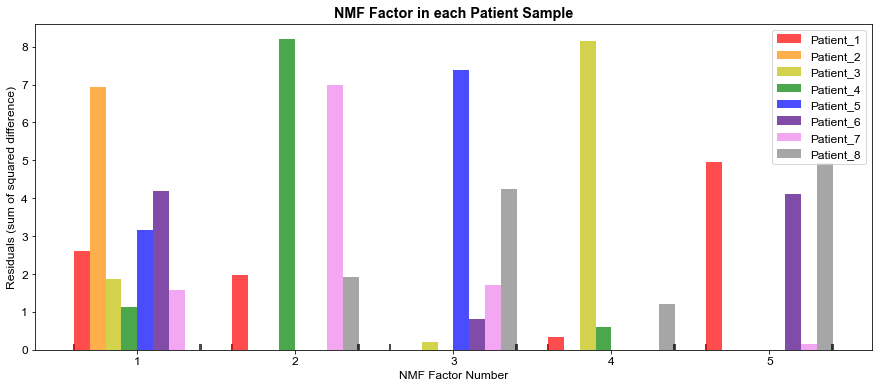

In [77]:
pt1_values = res_nmf_bulks.loc[0].values
pt2_values = res_nmf_bulks.loc[1].values
pt3_values = res_nmf_bulks.loc[2].values
pt4_values = res_nmf_bulks.loc[3].values
pt5_values = res_nmf_bulks.loc[4].values
pt6_values = res_nmf_bulks.loc[5].values
pt7_values = res_nmf_bulks.loc[6].values
pt8_values = res_nmf_bulks.loc[7].values

# Define custom colors
custom_colors = ['r', 'darkorange', 'y', 'g', 'b', 'indigo', 'violet', 'grey']

# Create x-coordinates for the bars
x_coordinates = np.arange(len(pt1_values)) + 1

# Width of each bar
bar_width = 0.1

# Set the font to Arial for all text
plt.rcParams['font.family'] = 'Arial'

plt.figure(figsize=(15, 6))

# Plot "Classic Bulks" residuals
plt.bar(x_coordinates - (bar_width * 4), 0.15, width=0.015, alpha=0.7, color='black')
plt.bar(x_coordinates - (bar_width * 3.5), pt1_values, width=bar_width, alpha=0.7, label='Patient_1', color=custom_colors[0])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates - (bar_width * 2.5), pt2_values, width=bar_width, alpha=0.7, label='Patient_2', color=custom_colors[1])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates - (bar_width * 1.5), pt3_values, width=bar_width, alpha=0.7, label='Patient_3', color=custom_colors[2])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates - (bar_width * 0.5), pt4_values, width=bar_width, alpha=0.7, label='Patient_4', color=custom_colors[3])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + (bar_width * 0.5), pt5_values, width=bar_width, alpha=0.7, label='Patient_5', color=custom_colors[4])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + (bar_width * 1.5), pt6_values, width=bar_width, alpha=0.7, label='Patient_6', color=custom_colors[5])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + (bar_width * 2.5), pt7_values, width=bar_width, alpha=0.7, label='Patient_7', color=custom_colors[6])

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + (bar_width * 3.5), pt8_values, width=bar_width, alpha=0.7, label='Patient_8', color=custom_colors[7])
plt.bar(x_coordinates + (bar_width * 4), 0.15, width=0.015, alpha=0.7, color='black')
plt.xlabel('NMF Factor Number')
plt.ylabel('Residuals (sum of squared difference)')

# Set the title to bold
plt.title('NMF Factor in each Patient Sample', fontweight='bold')

plt.xticks(x_coordinates)  # Adjust x-axis labels

# Move the legend to the upper right corner
plt.legend()

plt.show()

In [82]:
# Extract the third row
num = 2
third_row = residuals_bulks.values[num, :]  # Note: Python uses 0-based indexing, so the third row is at index 2

# Get the indices of the top 10 genes with the highest expression
top_10_genes_indices = np.argsort(third_row)[::-1][:10]

# Extract the gene names corresponding to the top 10 indices
gene_names_top_10 = residuals_bulks.columns[top_10_genes_indices]  # Replace 'your_gene_names' with the actual names of your genes

print(f"Top 10 most expressed genes in the {num}sample:")
for gene_name in gene_names_top_10:
    print(gene_name)

Top 10 most expressed genes in the 2sample:
PREX2
GLI3
SLC43A3
ADGRG1
PTPRF
CDH1
SLC39A14
LTBP2
ANPEP
FOLR1
